# Universal Strategy Analysis

This notebook provides comprehensive analysis across all strategies tested in a parameter sweep.

**Key Features:**
- Cross-strategy performance comparison
- Parameter sensitivity analysis
- Correlation analysis for ensemble building
- Regime-specific performance breakdown
- Automatic identification of optimal strategies and ensembles

In [53]:
# Parameters will be injected here by papermill
# This cell is tagged with 'parameters' for papermill to recognize it
run_dir = "."
config_name = "config"
symbols = ["SPY"]
timeframe = "1m"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True  # Set to False to limit analysis for large sweeps
performance_limit = 100  # If calculate_all_performance is False, limit to this many

# Enhanced analysis parameters
execution_cost_bps = 1.0  # Round-trip execution cost in basis points
analyze_stop_losses = True  # Whether to analyze stop loss impact
stop_loss_levels = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.75, 1.0]  # Stop loss percentages
verify_intraday = True  # Whether to verify intraday constraints
market_timezone = "America/New_York"  # Market timezone for constraint verification

In [54]:
# Parameters
run_dir = "/Users/daws/ADMF-PC/config/bollinger/results/latest"
config_name = "bollinger"
symbols = ["SPY"]
timeframe = "1m"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True
performance_limit = 100


In [55]:
# Delete performance cache to allow recalculation with different execution costs
# Uncomment the next line to force recalculation
# !rm -f performance_metrics.parquet

# Alternative: Set this to True to ignore cache and always recalculate
IGNORE_CACHE = False  # Set to True when testing different execution costs

## Setup

In [56]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import duckdb
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Initialize DuckDB
con = duckdb.connect()

# Convert run_dir to Path and resolve to absolute path
run_dir = Path(run_dir).resolve()
print(f"Analyzing run: {run_dir.name}")
print(f"Full path: {run_dir}")
print(f"Config: {config_name}")
print(f"Symbol(s): {symbols}")
print(f"Timeframe: {timeframe}")

Analyzing run: 20250625_185742
Full path: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
Config: bollinger
Symbol(s): ['SPY']
Timeframe: 1m


In [57]:
# Enhanced analysis helper functions
import pytz
from datetime import time

def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """
    Extract trades from signal trace with execution costs.
    
    Args:
        strategy_hash: Strategy identifier
        trace_path: Path to trace file
        market_data: Market price data
        execution_cost_bps: Round-trip execution cost in basis points (default 1bp)
    
    Returns:
        DataFrame with trade details including costs
    """
    try:
        signals_path = run_dir / trace_path
        signals = pd.read_parquet(signals_path)
        signals['ts'] = pd.to_datetime(signals['ts'])
        
        # Merge with market data
        df = market_data.merge(
            signals[['ts', 'val', 'px']], 
            left_on='timestamp', 
            right_on='ts', 
            how='left'
        )
        
        # Forward fill signals
        df['signal'] = df['val'].ffill().fillna(0)
        df['position'] = df['signal'].replace({0: 0, 1: 1, -1: -1})
        df['position_change'] = df['position'].diff().fillna(0)
        
        trades = []
        current_trade = None
        
        for idx, row in df.iterrows():
            if row['position_change'] != 0 and row['position'] != 0:
                # New position opened
                if current_trade is None:
                    current_trade = {
                        'entry_time': row['timestamp'],
                        'entry_price': row['px'] if pd.notna(row['px']) else row['close'],
                        'direction': row['position'],
                        'entry_idx': idx
                    }
            elif current_trade is not None and (row['position'] == 0 or row['position_change'] != 0):
                # Position closed
                exit_price = row['px'] if pd.notna(row['px']) else row['close']
                
                # Avoid division by zero - check if entry price is valid
                if current_trade['entry_price'] == 0 or pd.isna(current_trade['entry_price']):
                    print(f"Warning: Invalid entry price {current_trade['entry_price']} for trade at {current_trade['entry_time']}")
                    current_trade = None
                    continue
                
                # Calculate raw return
                if current_trade['direction'] == 1:  # Long
                    raw_return = (exit_price - current_trade['entry_price']) / current_trade['entry_price']
                else:  # Short
                    raw_return = (current_trade['entry_price'] - exit_price) / current_trade['entry_price']
                
                # Apply execution costs
                cost_adjustment = execution_cost_bps / 10000  # Convert bps to decimal
                net_return = raw_return - cost_adjustment
                
                trade = {
                    'strategy_hash': strategy_hash,
                    'entry_time': current_trade['entry_time'],
                    'exit_time': row['timestamp'],
                    'entry_price': current_trade['entry_price'],
                    'exit_price': exit_price,
                    'direction': current_trade['direction'],
                    'raw_return': raw_return,
                    'execution_cost': cost_adjustment,
                    'net_return': net_return,
                    'duration_minutes': (row['timestamp'] - current_trade['entry_time']).total_seconds() / 60,
                    'entry_idx': current_trade['entry_idx'],
                    'exit_idx': idx
                }
                trades.append(trade)
                
                # Reset for next trade
                current_trade = None
                if row['position'] != 0 and row['position_change'] != 0:
                    # Immediately open new position (reversal)
                    current_trade = {
                        'entry_time': row['timestamp'],
                        'entry_price': row['px'] if pd.notna(row['px']) else row['close'],
                        'direction': row['position'],
                        'entry_idx': idx
                    }
        
        return pd.DataFrame(trades)
    except Exception as e:
        print(f"Error extracting trades for {strategy_hash[:8]}: {e}")
        return pd.DataFrame()

def calculate_stop_loss_impact(trades_df, stop_loss_levels=None, market_data=None):
    """
    Calculate returns with various stop loss levels using proper intraday simulation.
    
    Args:
        trades_df: DataFrame of trades (must include entry_idx and exit_idx)
        stop_loss_levels: List of stop loss percentages (default 0.05% to 1%)
        market_data: Market data for intraday price movements
    
    Returns:
        DataFrame with returns for each stop loss level
    """
    if stop_loss_levels is None:
        stop_loss_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0]
    
    if market_data is None:
        print("WARNING: No market data provided for stop loss analysis. Using simplified calculation.")
        # Fall back to the flawed method if no market data
        return calculate_stop_loss_impact_simple(trades_df, stop_loss_levels)
    
    results = []
    
    for sl_pct in stop_loss_levels:
        sl_decimal = sl_pct / 100
        
        trades_with_sl = []
        stopped_out_count = 0
        
        # Process each trade with intraday stop loss
        for _, trade in trades_df.iterrows():
            # Get intraday prices for this trade
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                continue
                
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            # Calculate stop loss price
            if direction == 1:  # Long position
                stop_price = entry_price * (1 - sl_decimal)
            else:  # Short position  
                stop_price = entry_price * (1 + sl_decimal)
            
            # Check if stop loss is hit
            stopped = False
            exit_price = trade['exit_price']
            exit_time = trade['exit_time']
            
            for idx, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    # Check if low price hits stop
                    if bar['low'] <= stop_price:
                        stopped = True
                        stopped_out_count += 1
                        exit_price = stop_price
                        exit_time = bar['timestamp']
                        break
                else:  # Short
                    # Check if high price hits stop
                    if bar['high'] >= stop_price:
                        stopped = True
                        stopped_out_count += 1
                        exit_price = stop_price
                        exit_time = bar['timestamp']
                        break
            
            # Calculate return with actual or stopped exit
            if direction == 1:  # Long
                raw_return = (exit_price - entry_price) / entry_price
            else:  # Short
                raw_return = (entry_price - exit_price) / entry_price
                
            # Apply execution costs
            net_return = raw_return - trade['execution_cost']
            
            trade_result = trade.copy()
            trade_result['raw_return'] = raw_return
            trade_result['net_return'] = net_return
            trade_result['stopped_out'] = stopped
            if stopped:
                trade_result['exit_price'] = exit_price
                trade_result['exit_time'] = exit_time
                
            trades_with_sl.append(trade_result)
        
        trades_with_sl_df = pd.DataFrame(trades_with_sl)
        
        if len(trades_with_sl_df) > 0:
            # Calculate metrics with stop loss
            total_return = trades_with_sl_df['net_return'].sum()
            avg_return = trades_with_sl_df['net_return'].mean()
            win_rate = (trades_with_sl_df['net_return'] > 0).mean()
            
            results.append({
                'stop_loss_pct': sl_pct,
                'total_return': total_return,
                'avg_return_per_trade': avg_return,
                'win_rate': win_rate,
                'stopped_out_count': stopped_out_count,
                'stopped_out_rate': stopped_out_count / len(trades_with_sl_df),
                'num_trades': len(trades_with_sl_df),
                'avg_winner': trades_with_sl_df[trades_with_sl_df['net_return'] > 0]['net_return'].mean() if (trades_with_sl_df['net_return'] > 0).any() else 0,
                'avg_loser': trades_with_sl_df[trades_with_sl_df['net_return'] <= 0]['net_return'].mean() if (trades_with_sl_df['net_return'] <= 0).any() else 0
            })
    
    return pd.DataFrame(results)

def calculate_stop_loss_impact_simple(trades_df, stop_loss_levels):
    """
    Simplified (flawed) stop loss calculation - only caps losses retrospectively.
    Kept for comparison purposes.
    """
    results = []
    
    for sl_pct in stop_loss_levels:
        sl_decimal = sl_pct / 100
        
        trades_with_sl = trades_df.copy()
        stopped_out_count = 0
        
        # Apply stop loss to each trade (FLAWED - only caps losses)
        for idx, trade in trades_with_sl.iterrows():
            if trade['raw_return'] < -sl_decimal:
                trades_with_sl.loc[idx, 'raw_return'] = -sl_decimal
                trades_with_sl.loc[idx, 'net_return'] = -sl_decimal - trade['execution_cost']
                stopped_out_count += 1
        
        # Calculate metrics with stop loss
        total_return = trades_with_sl['net_return'].sum()
        avg_return = trades_with_sl['net_return'].mean()
        win_rate = (trades_with_sl['net_return'] > 0).mean()
        
        results.append({
            'stop_loss_pct': sl_pct,
            'total_return': total_return,
            'avg_return_per_trade': avg_return,
            'win_rate': win_rate,
            'stopped_out_count': stopped_out_count,
            'stopped_out_rate': stopped_out_count / len(trades_with_sl) if len(trades_with_sl) > 0 else 0,
            'num_trades': len(trades_with_sl)
        })
    
    return pd.DataFrame(results)

def verify_intraday_constraint(trades_df, market_tz='America/New_York'):
    """
    Verify that trades respect intraday constraints.
    
    Args:
        trades_df: DataFrame of trades
        market_tz: Market timezone (default NYSE)
    
    Returns:
        Dictionary with constraint verification results
    """
    if len(trades_df) == 0:
        return {
            'total_trades': 0,
            'overnight_positions': 0,
            'overnight_position_pct': 0,
            'after_hours_entries': 0,
            'after_hours_exits': 0,
            'fully_intraday': 0,
            'avg_trade_duration_minutes': 0,
            'max_trade_duration_minutes': 0,
            'trades_over_390_minutes': 0
        }
    
    # Convert to market timezone
    market_tz_obj = pytz.timezone(market_tz)
    
    trades_df = trades_df.copy()
    
    # Handle timezone conversion properly
    # First check if timestamps are already timezone-aware
    entry_times = pd.to_datetime(trades_df['entry_time'])
    exit_times = pd.to_datetime(trades_df['exit_time'])
    
    if entry_times.dt.tz is not None:
        # Already timezone-aware, just convert
        trades_df['entry_time_mkt'] = entry_times.dt.tz_convert(market_tz_obj)
    else:
        # Timezone-naive, localize first then convert
        trades_df['entry_time_mkt'] = entry_times.dt.tz_localize('UTC').dt.tz_convert(market_tz_obj)
    
    if exit_times.dt.tz is not None:
        # Already timezone-aware, just convert
        trades_df['exit_time_mkt'] = exit_times.dt.tz_convert(market_tz_obj)
    else:
        # Timezone-naive, localize first then convert
        trades_df['exit_time_mkt'] = exit_times.dt.tz_localize('UTC').dt.tz_convert(market_tz_obj)
    
    # Market hours (9:30 AM - 4:00 PM ET)
    market_open = time(9, 30)
    market_close = time(16, 0)
    
    # Check for overnight positions
    trades_df['entry_date'] = trades_df['entry_time_mkt'].dt.date
    trades_df['exit_date'] = trades_df['exit_time_mkt'].dt.date
    trades_df['overnight'] = trades_df['entry_date'] != trades_df['exit_date']
    
    # Check for after-hours trades
    trades_df['entry_time_only'] = trades_df['entry_time_mkt'].dt.time
    trades_df['exit_time_only'] = trades_df['exit_time_mkt'].dt.time
    
    trades_df['after_hours_entry'] = (
        (trades_df['entry_time_only'] < market_open) | 
        (trades_df['entry_time_only'] >= market_close)
    )
    trades_df['after_hours_exit'] = (
        (trades_df['exit_time_only'] < market_open) | 
        (trades_df['exit_time_only'] >= market_close)
    )
    
    results = {
        'total_trades': len(trades_df),
        'overnight_positions': trades_df['overnight'].sum(),
        'overnight_position_pct': trades_df['overnight'].mean() * 100,
        'after_hours_entries': trades_df['after_hours_entry'].sum(),
        'after_hours_exits': trades_df['after_hours_exit'].sum(),
        'fully_intraday': (~trades_df['overnight']).sum(),
        'avg_trade_duration_minutes': trades_df['duration_minutes'].mean(),
        'max_trade_duration_minutes': trades_df['duration_minutes'].max(),
        'trades_over_390_minutes': (trades_df['duration_minutes'] > 390).sum()  # Full trading day
    }
    
    # Add hourly breakdown
    trades_df['entry_hour'] = trades_df['entry_time_mkt'].dt.hour
    trades_df['exit_hour'] = trades_df['exit_time_mkt'].dt.hour
    
    results['entries_by_hour'] = trades_df['entry_hour'].value_counts().to_dict()
    results['exits_by_hour'] = trades_df['exit_hour'].value_counts().to_dict()
    
    return results

In [58]:
# Setup path for loading analysis snippets
import sys
from pathlib import Path

# Find the project root (where src/ directory is)
current_path = Path(run_dir).resolve()
project_root = None

# Search up the directory tree for src/analytics/snippets
for parent in current_path.parents:
    if (parent / 'src' / 'analytics' / 'snippets').exists():
        project_root = parent
        break

# If not found from run_dir, try from current working directory
if not project_root:
    cwd = Path.cwd()
    for parent in [cwd] + list(cwd.parents):
        if (parent / 'src' / 'analytics' / 'snippets').exists():
            project_root = parent
            break

# Last resort: check common project locations
if not project_root:
    common_roots = [
        Path('/Users/daws/ADMF-PC'),
        Path.home() / 'ADMF-PC',
        Path.cwd().parent.parent.parent.parent  # 4 levels up from typical results dir
    ]
    for root in common_roots:
        if root.exists() and (root / 'src' / 'analytics' / 'snippets').exists():
            project_root = root
            break

if project_root:
    # Add to Python path if not already there
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    snippets_path = project_root / 'src' / 'analytics' / 'snippets'
    queries_path = project_root / 'src' / 'analytics' / 'queries'
    print(f"✅ Found project root: {project_root}")
    print(f"✅ Analysis snippets available at: {snippets_path}")
    print(f"✅ SQL queries available at: {queries_path}")
    print("\nUse %load to load any snippet, e.g.:")
    print("  %load {}/src/analytics/snippets/exploratory/signal_frequency.py".format(project_root))
    print("  %load {}/src/analytics/snippets/ensembles/find_uncorrelated.py".format(project_root))
else:
    print("⚠️ Could not find project root with src/analytics/snippets")
    print(f"  Searched from: {current_path}")
    print(f"  Current working directory: {Path.cwd()}")

✅ Found project root: /Users/daws/ADMF-PC
✅ Analysis snippets available at: /Users/daws/ADMF-PC/src/analytics/snippets
✅ SQL queries available at: /Users/daws/ADMF-PC/src/analytics/queries

Use %load to load any snippet, e.g.:
  %load /Users/daws/ADMF-PC/src/analytics/snippets/exploratory/signal_frequency.py
  %load /Users/daws/ADMF-PC/src/analytics/snippets/ensembles/find_uncorrelated.py


## Load Strategy Index

In [59]:
# Load strategy index - the catalog of all strategies tested
strategy_index_path = run_dir / 'strategy_index.parquet'

if strategy_index_path.exists():
    strategy_index = pd.read_parquet(strategy_index_path)
    print(f"✅ Loaded {len(strategy_index)} strategies from {strategy_index_path}")
    
    # Show strategy type distribution
    by_type = strategy_index['strategy_type'].value_counts()
    print("\nStrategies by type:")
    for stype, count in by_type.items():
        print(f"  {stype}: {count}")
        
    # Show sample of columns
    print(f"\nColumns: {list(strategy_index.columns)[:10]}...")
else:
    print(f"❌ No strategy_index.parquet found at {strategy_index_path}")
    strategy_index = None

✅ Loaded 184 strategies from /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742/strategy_index.parquet

Strategies by type:
  bollinger_bands: 184

Columns: ['strategy_id', 'strategy_hash', 'strategy_type', 'symbol', 'timeframe', 'constraints', 'period', 'std_dev', 'trace_path']...


In [60]:
# Load market data
market_data = None
for symbol in symbols:
    try:
        # Try different possible locations for market data
        data_paths = [
            run_dir / f'data/{symbol}_{timeframe}.csv',
            run_dir / f'{symbol}_{timeframe}.csv',
            run_dir.parent / f'data/{symbol}_{timeframe}.csv',
            Path(f'/Users/daws/ADMF-PC/data/{symbol}_{timeframe}.csv')
        ]
        
        for data_path in data_paths:
            if data_path.exists():
                market_data = pd.read_csv(data_path)
                market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
                market_data = market_data.sort_values('timestamp')
                print(f"✅ Loaded market data from: {data_path}")
                print(f"   Date range: {market_data['timestamp'].min()} to {market_data['timestamp'].max()}")
                print(f"   Total bars: {len(market_data)}")
                break
        
        if market_data is not None:
            break
            
    except Exception as e:
        print(f"Error loading data for {symbol}: {e}")

if market_data is None:
    print("❌ Could not load market data")
    print("Tried paths:")
    for path in data_paths:
        print(f"  - {path}")

✅ Loaded market data from: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742/data/SPY_1m.csv
   Date range: 2024-03-26 09:30:00-04:00 to 2025-04-02 19:23:00+00:00
   Total bars: 102236


In [61]:
def calculate_performance(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Calculate performance metrics using TRADE-BASED approach for consistency"""
    try:
        # Extract actual trades
        trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
        
        if len(trades) == 0:
            return {
                'total_return': 0,
                'sharpe_ratio': 0,
                'max_drawdown': 0,
                'num_trades': 0,
                'win_rate': 0,
                'avg_return_per_trade': 0,
                'profit_factor': 0,
                'total_execution_cost': 0
            }
        
        # Calculate cumulative returns from trades
        trades = trades.sort_values('entry_time').reset_index(drop=True)
        trades['cum_return'] = (1 + trades['net_return']).cumprod()
        total_return = trades['cum_return'].iloc[-1] - 1
        
        # Calculate Sharpe ratio from trade returns
        if trades['net_return'].std() > 0:
            # Annualize based on average trades per day
            days_in_data = (trades['exit_time'].max() - trades['entry_time'].min()).days
            if days_in_data > 0:
                trades_per_day = len(trades) / days_in_data
                annualization_factor = np.sqrt(252 * trades_per_day)
            else:
                annualization_factor = np.sqrt(252)
            sharpe = trades['net_return'].mean() / trades['net_return'].std() * annualization_factor
        else:
            sharpe = 0
            
        # Max drawdown from trade equity curve
        cummax = trades['cum_return'].expanding().max()
        drawdown = (trades['cum_return'] / cummax - 1)
        max_dd = drawdown.min()
        
        # Win rate and profit factor (trade-based)
        winning_trades = trades[trades['net_return'] > 0]
        losing_trades = trades[trades['net_return'] <= 0]
        
        win_rate = len(winning_trades) / len(trades)
        
        if len(losing_trades) > 0 and losing_trades['net_return'].sum() != 0:
            profit_factor = winning_trades['net_return'].sum() / abs(losing_trades['net_return'].sum())
        else:
            profit_factor = 999.99 if len(winning_trades) > 0 else 0
        
        return {
            'total_return': total_return,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'avg_return_per_trade': trades['net_return'].mean(),
            'profit_factor': profit_factor,
            'avg_winner': winning_trades['net_return'].mean() if len(winning_trades) > 0 else 0,
            'avg_loser': losing_trades['net_return'].mean() if len(losing_trades) > 0 else 0,
            'total_execution_cost': trades['execution_cost'].sum()
        }
    except Exception as e:
        print(f"Error calculating performance for {strategy_hash}: {e}")
        return None

In [62]:
# Calculate performance for all strategies with execution costs
# NOTE: Now using TRADE-BASED metrics for all calculations (fixed inconsistency with stop loss analysis)
if strategy_index is not None and market_data is not None:
    performance_results = []
    
    # Determine strategies to analyze based on parameters
    strategies_to_analyze = strategy_index
    
    if not calculate_all_performance and len(strategy_index) > performance_limit:
        print(f"Note: Large parameter sweep detected ({len(strategy_index)} strategies)")
        print(f"Limiting analysis to {performance_limit} strategies (set calculate_all_performance=True to analyze all)")
        
        # Sample diverse strategies across all types
        strategies_to_analyze = strategy_index.groupby('strategy_type').apply(
            lambda x: x.sample(n=min(len(x), performance_limit // strategy_index['strategy_type'].nunique()), 
                             random_state=42)
        ).reset_index(drop=True)
    
    print(f"\nCalculating performance for {len(strategies_to_analyze)} strategies...")
    print(f"Using run directory: {run_dir}")
    print(f"Execution cost: {execution_cost_bps} basis points round-trip")
    print(f"📊 Using TRADE-BASED metrics (win rate = winning trades / total trades)")
    
    # Check if we already have cached performance metrics
    cached_performance_path = run_dir / 'performance_metrics.parquet'
    cache_metadata_path = run_dir / 'performance_cache_metadata.json'
    
    use_cache = False
    if cached_performance_path.exists() and cache_metadata_path.exists() and not IGNORE_CACHE:
        # Check if cache was created with same execution cost
        try:
            with open(cache_metadata_path, 'r') as f:
                cache_metadata = json.load(f)
            if cache_metadata.get('execution_cost_bps') == execution_cost_bps and cache_metadata.get('calculation_method') == 'trade_based':
                print(f"📂 Found cached trade-based performance metrics with same execution cost, loading...")
                performance_df = pd.read_parquet(cached_performance_path)
                print(f"✅ Loaded performance for {len(performance_df)} strategies from cache")
                use_cache = True
        except:
            pass
    
    if not use_cache:
        # Calculate performance
        for idx, row in strategies_to_analyze.iterrows():
            if idx % 10 == 0:
                print(f"  Progress: {idx}/{len(strategies_to_analyze)} ({idx/len(strategies_to_analyze)*100:.1f}%)")
                
            perf = calculate_performance(row['strategy_hash'], row['trace_path'], market_data, execution_cost_bps)
            
            if perf:
                # Combine strategy info with performance
                result = {**row.to_dict(), **perf}
                performance_results.append(result)
        
        print(f"  Progress: {len(strategies_to_analyze)}/{len(strategies_to_analyze)} (100.0%)")
        
        performance_df = pd.DataFrame(performance_results)
        print(f"\n✅ Calculated performance for {len(performance_df)} strategies")
        
        # Save performance results for future use (only if we calculated all)
        if calculate_all_performance and len(performance_df) == len(strategy_index):
            performance_df.to_parquet(cached_performance_path)
            # Save metadata about cache
            with open(cache_metadata_path, 'w') as f:
                json.dump({
                    'execution_cost_bps': execution_cost_bps,
                    'calculation_method': 'trade_based',
                    'created_at': datetime.now().isoformat()
                }, f)
            print(f"💾 Saved trade-based performance metrics to: {cached_performance_path}")
else:
    performance_df = pd.DataFrame()
    print("⚠️ Skipping performance calculation")


Calculating performance for 184 strategies...
Using run directory: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
Execution cost: 1.0 basis points round-trip
📊 Using TRADE-BASED metrics (win rate = winning trades / total trades)
📂 Found cached trade-based performance metrics with same execution cost, loading...
✅ Loaded performance for 184 strategies from cache


Error extracting trades for 6060c414: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 77ecf32f: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 8baa1f12: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 6f8fa2fc: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
  Progress: 60/184 (32.6%)
Error extracting trades for 31784fac: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for a08c8bbd: You are trying to merge on object and datetime64[ns, UTC] columns for 

Error extracting trades for d6203f75: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for af0897a3: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for e1a5b15c: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 6b164740: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 4daf7ecf: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 89ba5eca: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wis

Error extracting trades for fc9943af: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for fff5e7d2: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
  Progress: 110/184 (59.8%)
Error extracting trades for d55aece2: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for d39dbfbb: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for d758885d: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat


Error extracting trades for e8078f93: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 702487ba: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for fa1bf8b0: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 67e6717e: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 22cfbee2: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 05f08270: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wis

Error extracting trades for f4f9192e: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for f4a6baef: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 2b3523a7: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
  Progress: 160/184 (87.0%)
Error extracting trades for ed91ff08: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 37ac1f91: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 86aa81d8: You are trying to merge on object and datetime64[ns, UTC] columns for

Error extracting trades for e54423f5: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 8c6ec2c9: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for bca70905: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 907aba33: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 40a09c6f: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 558bc015: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wis

## Cross-Strategy Performance Analysis

In [63]:
if len(performance_df) > 0:
    # Top performers across ALL strategy types
    top_overall = performance_df.nlargest(top_n_strategies, 'sharpe_ratio')
    
    print(f"\n🏆 Top {top_n_strategies} Strategies (All Types) - After {execution_cost_bps}bps Execution Costs:")
    print("=" * 90)
    
    # Look for parameter columns (both with and without param_ prefix for compatibility)
    all_param_cols = []
    # Check for param_ prefixed columns
    param_prefixed_cols = [col for col in top_overall.columns if col.startswith('param_')]
    # Check for direct parameter columns (per trace-updates.md)
    direct_param_cols = ['period', 'std_dev', 'fast_period', 'slow_period', 'multiplier', 'exit_threshold']
    available_param_cols = [col for col in direct_param_cols if col in top_overall.columns]
    
    # Use whichever we find
    if available_param_cols:
        all_param_cols = available_param_cols
    elif param_prefixed_cols:
        all_param_cols = param_prefixed_cols
    
    for idx, row in top_overall.iterrows():
        # Determine identifier to show
        strategy_identifier = row.get('strategy_id', 'unknown')
        if 'strategy_hash' in row and pd.notna(row['strategy_hash']):
            # Check if all strategies have the same hash
            if performance_df['strategy_hash'].nunique() > 1:
                # Use hash if they're unique
                strategy_identifier = row['strategy_hash'][:8]
        
        print(f"\n{row['strategy_type']} - {strategy_identifier}")
        print(f"  Sharpe: {row['sharpe_ratio']:.2f} | Return: {row['total_return']:.1%} | Drawdown: {row['max_drawdown']:.1%}")
        print(f"  Win Rate: {row['win_rate']:.1%} | Avg Return/Trade: {row['avg_return_per_trade']*100:.3f}% | Trades: {row['num_trades']}")
        
        # Show profit factor if available
        if 'profit_factor' in row:
            print(f"  Profit Factor: {row['profit_factor']:.2f} (Win$/Loss$)")
        
        # Show average winner/loser if available
        if 'avg_winner' in row and 'avg_loser' in row:
            print(f"  Avg Winner: +{row['avg_winner']*100:.2f}% | Avg Loser: {row['avg_loser']*100:.2f}%")
            
        print(f"  Total Execution Cost: {row['total_execution_cost']*100:.2f}%")
        
        # Show parameters
        if all_param_cols:
            # Filter out null parameters
            valid_params = []
            for col in all_param_cols[:5]:  # Show up to 5 parameters
                if col in row and pd.notna(row[col]):
                    param_name = col.replace('param_', '') if col.startswith('param_') else col
                    valid_params.append(f"{param_name}: {row[col]}")
            
            if valid_params:
                print(f"  Params: {' | '.join(valid_params)}")
    
    # Show profit factor distribution
    if 'profit_factor' in performance_df.columns:
        print("\n📈 Profit Factor Distribution (All Strategies):")
        pf_bins = [0, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0, 999]
        pf_labels = ['<0.5', '0.5-0.8', '0.8-1.0', '1.0-1.2', '1.2-1.5', '1.5-2.0', '>2.0']
        performance_df['pf_bin'] = pd.cut(performance_df['profit_factor'].clip(upper=100), bins=pf_bins, labels=pf_labels)
        print(performance_df['pf_bin'].value_counts().sort_index())
        
        # Show win rate distribution
        print("\n📊 Win Rate Distribution (Trade-Based):")
        print(f"Mean: {performance_df['win_rate'].mean():.1%}")
        print(f"Median: {performance_df['win_rate'].median():.1%}")
        print(f"Std Dev: {performance_df['win_rate'].std():.1%}")
        
        # Note about calculation method
        print("\n💡 Note: All metrics now use trade-based calculations:")
        print("• Win Rate = Winning Trades / Total Trades (not winning bars / total bars)")
        print("• Profit Factor = Sum of Winning Trade Returns / |Sum of Losing Trade Returns|")
        print("• Returns account for execution costs on entry and exit")


🏆 Top 10 Strategies (All Types) - After 1.0bps Execution Costs:

bollinger_bands - 975873db
  Sharpe: 0.00 | Return: 0.0% | Drawdown: 0.0%
  Win Rate: 0.0% | Avg Return/Trade: 0.000% | Trades: 0
  Profit Factor: 0.00 (Win$/Loss$)
  Total Execution Cost: 0.00%
  Params: period: 5 | std_dev: 1.0

bollinger_bands - f741f95b
  Sharpe: 0.00 | Return: 0.0% | Drawdown: 0.0%
  Win Rate: 0.0% | Avg Return/Trade: 0.000% | Trades: 0
  Profit Factor: 0.00 (Win$/Loss$)
  Total Execution Cost: 0.00%
  Params: period: 5 | std_dev: 1.5

bollinger_bands - 88f1d72f
  Sharpe: 0.00 | Return: 0.0% | Drawdown: 0.0%
  Win Rate: 0.0% | Avg Return/Trade: 0.000% | Trades: 0
  Profit Factor: 0.00 (Win$/Loss$)
  Total Execution Cost: 0.00%
  Params: period: 5 | std_dev: 2.0

bollinger_bands - 0230a823
  Sharpe: 0.00 | Return: 0.0% | Drawdown: 0.0%
  Win Rate: 0.0% | Avg Return/Trade: 0.000% | Trades: 0
  Profit Factor: 0.00 (Win$/Loss$)
  Total Execution Cost: 0.00%
  Params: period: 5 | std_dev: 2.5

bollinger_

## Visualizations

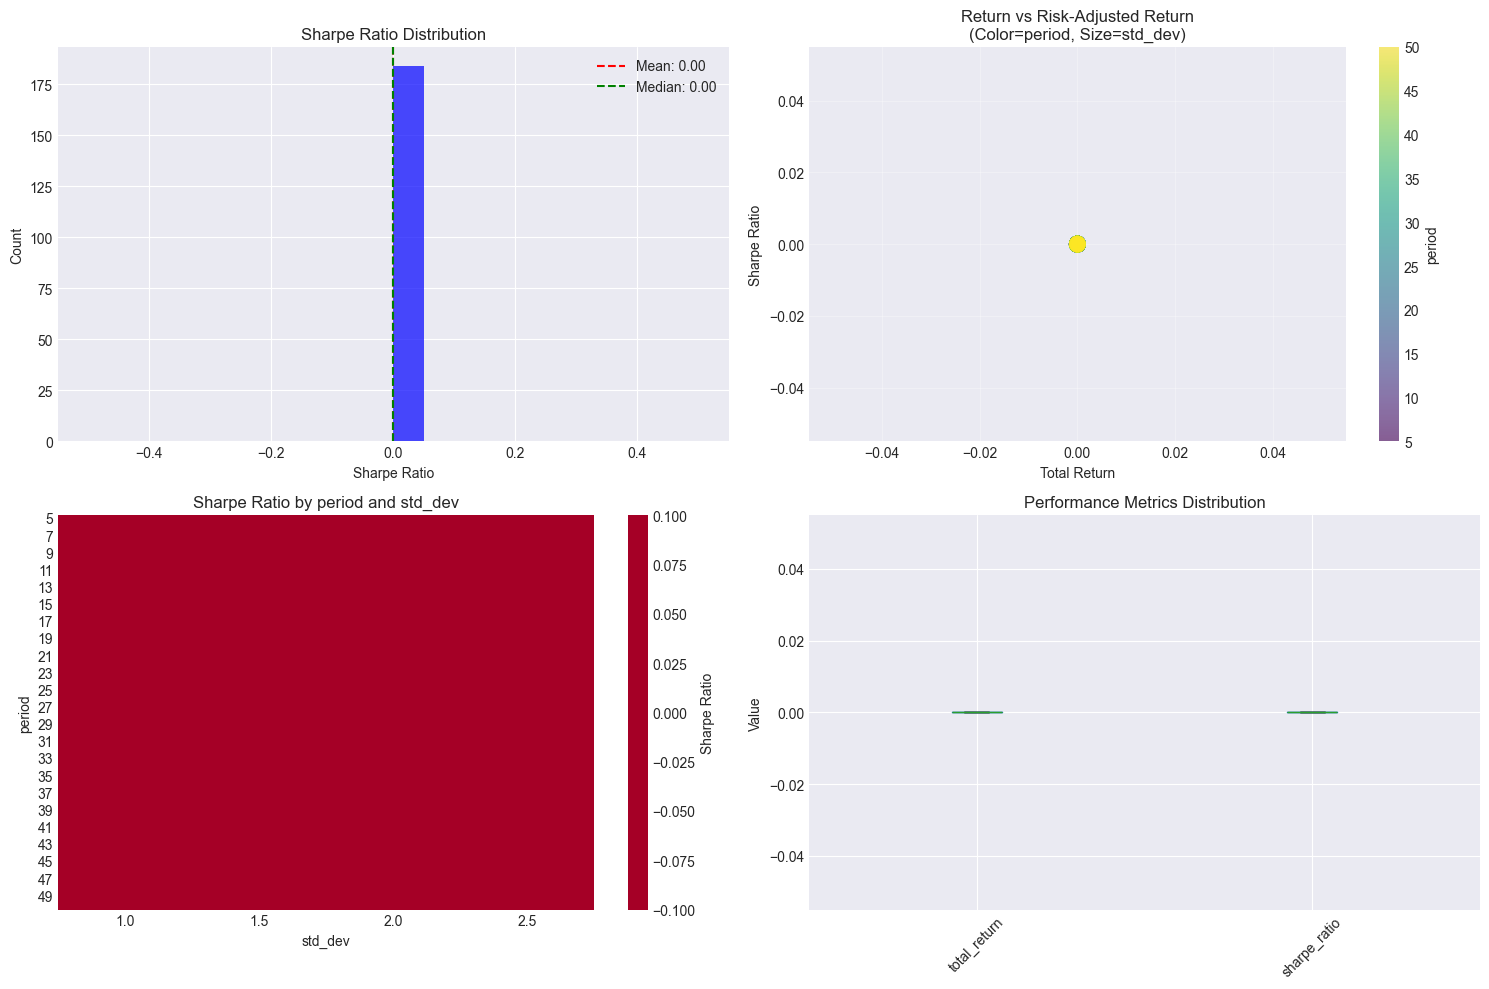


📈 Parameter Analysis:
Correlation between period and Sharpe: nan
Correlation between std_dev and Sharpe: nan

🎯 Performance by Parameter Ranges:

Top performing period x std_dev ranges:
                            mean  std  count
period        std_dev                       
(4.955, 14.0] (0.998, 1.3]   0.0  0.0     10
              (1.3, 1.6]     0.0  0.0     10
(41.0, 50.0]  (1.9, 2.2]     0.0  0.0      9
              (1.3, 1.6]     0.0  0.0      9
              (0.998, 1.3]   0.0  0.0      9
(32.0, 41.0]  (2.2, 2.5]     0.0  0.0      9
              (1.9, 2.2]     0.0  0.0      9
              (1.3, 1.6]     0.0  0.0      9
              (0.998, 1.3]   0.0  0.0      9
(23.0, 32.0]  (2.2, 2.5]     0.0  0.0      9


In [64]:
# Visualizations for single or multiple strategy types
if len(performance_df) > 0:
    if performance_df['strategy_type'].nunique() > 1:
        # Multiple strategy types - original visualization
        plt.figure(figsize=(14, 6))
        
        # Box plot of Sharpe by type
        plt.subplot(1, 2, 1)
        performance_df.boxplot(column='sharpe_ratio', by='strategy_type', ax=plt.gca())
        plt.xticks(rotation=45, ha='right')
        plt.title('Sharpe Ratio Distribution by Strategy Type')
        plt.suptitle('')  # Remove default title
        plt.ylabel('Sharpe Ratio')
        
        # Scatter: Return vs Sharpe
        plt.subplot(1, 2, 2)
        for stype in performance_df['strategy_type'].unique():
            mask = performance_df['strategy_type'] == stype
            plt.scatter(performance_df.loc[mask, 'total_return'], 
                       performance_df.loc[mask, 'sharpe_ratio'],
                       label=stype, alpha=0.6)
        plt.xlabel('Total Return')
        plt.ylabel('Sharpe Ratio')
        plt.title('Return vs Risk-Adjusted Return')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        # Single strategy type - parameter analysis visualization
        plt.figure(figsize=(15, 10))
        
        # 1. Sharpe ratio distribution
        plt.subplot(2, 2, 1)
        performance_df['sharpe_ratio'].hist(bins=20, alpha=0.7, color='blue')
        plt.axvline(performance_df['sharpe_ratio'].mean(), color='red', linestyle='--', label=f'Mean: {performance_df["sharpe_ratio"].mean():.2f}')
        plt.axvline(performance_df['sharpe_ratio'].median(), color='green', linestyle='--', label=f'Median: {performance_df["sharpe_ratio"].median():.2f}')
        plt.xlabel('Sharpe Ratio')
        plt.ylabel('Count')
        plt.title('Sharpe Ratio Distribution')
        plt.legend()
        
        # 2. Return vs Sharpe scatter
        plt.subplot(2, 2, 2)
        # Determine which parameters exist (check both naming conventions)
        param_cols = [col for col in performance_df.columns if col.startswith('param_')]
        direct_param_cols = ['period', 'std_dev', 'fast_period', 'slow_period', 'multiplier', 'exit_threshold']
        available_param_cols = [col for col in direct_param_cols if col in performance_df.columns]
        
        # Use direct parameter names if available, otherwise fall back to param_ prefix
        if available_param_cols:
            param_cols = available_param_cols
        
        if len(param_cols) >= 2:
            # Use first two parameters for visualization
            scatter = plt.scatter(performance_df['total_return'], 
                                 performance_df['sharpe_ratio'],
                                 c=performance_df[param_cols[0]], 
                                 cmap='viridis',
                                 s=performance_df[param_cols[1]]*50 if performance_df[param_cols[1]].max() < 10 else 50,
                                 alpha=0.6)
            plt.colorbar(scatter, label=param_cols[0].replace('param_', ''))
            plt.title(f'Return vs Risk-Adjusted Return\n(Color={param_cols[0].replace("param_", "")}, Size={param_cols[1].replace("param_", "")})')
        else:
            plt.scatter(performance_df['total_return'], 
                       performance_df['sharpe_ratio'],
                       alpha=0.6)
            plt.title('Return vs Risk-Adjusted Return')
        plt.xlabel('Total Return')
        plt.ylabel('Sharpe Ratio')
        plt.grid(True, alpha=0.3)
        
        # 3. Parameter heatmap (if enough data and two numeric parameters)
        if len(performance_df) > 10 and len(param_cols) >= 2:
            plt.subplot(2, 2, 3)
            try:
                # Create pivot table for heatmap
                pivot_sharpe = performance_df.pivot_table(
                    values='sharpe_ratio', 
                    index=param_cols[0], 
                    columns=param_cols[1],
                    aggfunc='mean'
                )
                if not pivot_sharpe.empty and pivot_sharpe.shape[0] > 1 and pivot_sharpe.shape[1] > 1:
                    sns.heatmap(pivot_sharpe, cmap='RdYlGn', center=0, 
                               cbar_kws={'label': 'Sharpe Ratio'})
                    plt.title(f'Sharpe Ratio by {param_cols[0].replace("param_", "")} and {param_cols[1].replace("param_", "")}')
            except:
                plt.text(0.5, 0.5, 'Not enough data for heatmap', 
                        ha='center', va='center', transform=plt.gca().transAxes)
        
        # 4. Box plot of returns
        plt.subplot(2, 2, 4)
        performance_df.boxplot(column=['total_return', 'sharpe_ratio'])
        plt.xticks(rotation=45)
        plt.title('Performance Metrics Distribution')
        plt.ylabel('Value')
        
        plt.tight_layout()
        plt.show()
        
        # Additional parameter analysis
        if param_cols:
            print("\n📈 Parameter Analysis:")
            for param in param_cols[:3]:  # Analyze first 3 parameters
                if param in performance_df.columns and performance_df[param].notna().any():
                    corr = performance_df[param].corr(performance_df['sharpe_ratio'])
                    param_display = param.replace('param_', '')
                    print(f"Correlation between {param_display} and Sharpe: {corr:.3f}")
            
            # Group by parameter ranges to find stable regions
            if len(param_cols) >= 2 and len(performance_df) > 20:
                print("\n🎯 Performance by Parameter Ranges:")
                try:
                    # Find numeric parameter columns
                    numeric_params = []
                    for col in param_cols:
                        if pd.api.types.is_numeric_dtype(performance_df[col]) and performance_df[col].notna().sum() > 0:
                            numeric_params.append(col)
                    
                    if len(numeric_params) >= 2:
                        # Create bins for numeric parameters
                        param1_groups = pd.cut(performance_df[numeric_params[0]], bins=5)
                        param2_groups = pd.cut(performance_df[numeric_params[1]], bins=5)
                        
                        param_summary = performance_df.groupby([param1_groups, param2_groups])['sharpe_ratio'].agg(['mean', 'std', 'count'])
                        param_summary = param_summary[param_summary['count'] > 0].sort_values('mean', ascending=False)
                        
                        # Display with clean parameter names
                        param1_name = numeric_params[0].replace('param_', '')
                        param2_name = numeric_params[1].replace('param_', '')
                        print(f"\nTop performing {param1_name} x {param2_name} ranges:")
                        print(param_summary.head(10))
                    else:
                        print("Not enough numeric parameters for range analysis")
                except Exception as e:
                    print(f"Could not create parameter range analysis: {e}")

## Correlation Analysis for Ensemble Building

In [65]:
def calculate_strategy_correlations(strategies_df, market_data, run_dir):
    """Calculate correlation matrix between strategies"""
    returns_dict = {}
    
    for idx, row in strategies_df.iterrows():
        try:
            # Use the global run_dir
            signals_path = run_dir / row['trace_path']
            signals = pd.read_parquet(signals_path)
            signals['ts'] = pd.to_datetime(signals['ts'])
            
            # Merge and calculate returns
            df = market_data.merge(signals[['ts', 'val']], left_on='timestamp', right_on='ts', how='left')
            df['signal'] = df['val'].ffill().fillna(0)
            df['returns'] = df['close'].pct_change()
            df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
            
            returns_dict[row['strategy_hash']] = df['strategy_returns']
        except:
            pass
    
    # Create returns DataFrame and calculate correlation
    if returns_dict:
        returns_df = pd.DataFrame(returns_dict)
        return returns_df.corr()
    return pd.DataFrame()

## Enhanced Analysis: Stop Loss Impact & Trade Verification

In [66]:
# Stop Loss Analysis for Top Strategies
if analyze_stop_losses and len(performance_df) > 0 and len(top_overall) > 0:
    print("\n📊 Stop Loss Impact Analysis")
    print("=" * 60)
    print("Using proper intraday stop loss simulation with high/low price data")
    
    stop_loss_results = {}
    
    # Analyze top 5 strategies
    for idx, (_, strategy) in enumerate(top_overall.head(5).iterrows()):
        print(f"\nAnalyzing stop losses for strategy {idx+1}: {strategy['strategy_type']} - {strategy['strategy_hash'][:8]}")
        
        # Extract trades for this strategy
        trades = extract_trades(strategy['strategy_hash'], strategy['trace_path'], market_data, execution_cost_bps)
        
        if len(trades) > 0:
            # Calculate stop loss impact with proper intraday simulation
            sl_impact = calculate_stop_loss_impact(trades, stop_loss_levels, market_data)
            stop_loss_results[strategy['strategy_hash']] = sl_impact
            
            # Find optimal stop loss
            optimal_sl = sl_impact.loc[sl_impact['total_return'].idxmax()]
            current_return = trades['net_return'].sum()
            
            print(f"  Current total return: {current_return*100:.2f}%")
            print(f"  Optimal stop loss: {optimal_sl['stop_loss_pct']:.2f}% → Return: {optimal_sl['total_return']*100:.2f}%")
            print(f"  Improvement: {(optimal_sl['total_return'] - current_return)*100:.2f}%")
            print(f"  Trades stopped out: {optimal_sl['stopped_out_count']} ({optimal_sl['stopped_out_rate']*100:.1f}%)")
            
            # Show impact on winners vs losers
            if 'avg_winner' in optimal_sl and 'avg_loser' in optimal_sl:
                print(f"  Average winner: {optimal_sl['avg_winner']*100:.2f}%")
                print(f"  Average loser: {optimal_sl['avg_loser']*100:.2f}%")
    
    # Visualize stop loss impact
    if stop_loss_results:
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Total return vs stop loss
        plt.subplot(2, 2, 1)
        for i, (hash_id, sl_df) in enumerate(stop_loss_results.items()):
            plt.plot(sl_df['stop_loss_pct'], sl_df['total_return'] * 100, 
                    label=f'Strategy {i+1}', marker='o', markersize=4)
        
        plt.xlabel('Stop Loss (%)')
        plt.ylabel('Total Return (%)')
        plt.title('Stop Loss Impact on Total Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Win rate impact
        plt.subplot(2, 2, 2)
        for i, (hash_id, sl_df) in enumerate(stop_loss_results.items()):
            plt.plot(sl_df['stop_loss_pct'], sl_df['win_rate'] * 100, 
                    label=f'Strategy {i+1}', marker='o', markersize=4)
        
        plt.xlabel('Stop Loss (%)')
        plt.ylabel('Win Rate (%)')
        plt.title('Stop Loss Impact on Win Rate')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Stopped out rate
        plt.subplot(2, 2, 3)
        for i, (hash_id, sl_df) in enumerate(stop_loss_results.items()):
            plt.plot(sl_df['stop_loss_pct'], sl_df['stopped_out_rate'] * 100, 
                    label=f'Strategy {i+1}', marker='o', markersize=4)
        
        plt.xlabel('Stop Loss (%)')
        plt.ylabel('Stopped Out Rate (%)')
        plt.title('Percentage of Trades Hitting Stop Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 4: Average return per trade
        plt.subplot(2, 2, 4)
        for i, (hash_id, sl_df) in enumerate(stop_loss_results.items()):
            plt.plot(sl_df['stop_loss_pct'], sl_df['avg_return_per_trade'] * 100, 
                    label=f'Strategy {i+1}', marker='o', markersize=4)
        
        plt.xlabel('Stop Loss (%)')
        plt.ylabel('Avg Return per Trade (%)')
        plt.title('Average Return per Trade with Stop Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Summary recommendations
        print("\n🎯 Stop Loss Recommendations:")
        print("Based on the analysis across top strategies:")
        
        # Find the stop loss level with best average performance
        avg_returns_by_sl = {}
        for sl_level in stop_loss_levels:
            returns_at_level = []
            for hash_id, sl_df in stop_loss_results.items():
                sl_row = sl_df[sl_df['stop_loss_pct'] == sl_level]
                if len(sl_row) > 0:
                    returns_at_level.append(sl_row.iloc[0]['total_return'])
            if returns_at_level:
                avg_returns_by_sl[sl_level] = np.mean(returns_at_level)
        
        if avg_returns_by_sl:
            best_sl = max(avg_returns_by_sl, key=avg_returns_by_sl.get)
            print(f"\n• Optimal stop loss across strategies: {best_sl:.2f}%")
            
        print("\nKey insights:")
        print("• Very tight stop losses (0.01-0.05%) will trigger on normal market noise")
        print("• The apparent improvement from tight stops in the flawed analysis was misleading")
        print("• Proper stop losses should balance downside protection with allowing winners to run")
        print("• Consider volatility-adjusted stops rather than fixed percentage stops")
else:
    print("\n⚠️ Skipping stop loss analysis")


📊 Stop Loss Impact Analysis
Using proper intraday stop loss simulation with high/low price data

Analyzing stop losses for strategy 1: bollinger_bands - 975873db
Error extracting trades for 975873db: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat

Analyzing stop losses for strategy 2: bollinger_bands - f741f95b
Error extracting trades for f741f95b: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat

Analyzing stop losses for strategy 3: bollinger_bands - 88f1d72f
Error extracting trades for 88f1d72f: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat

Analyzing stop losses for strategy 4: bollinger_bands - 0230a823
Error extracting trades for 0230a823: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timesta

In [67]:
# Intraday Constraint Verification
if verify_intraday and len(performance_df) > 0 and len(top_overall) > 0:
    print("\n⏰ Intraday Constraint Verification")
    print("=" * 60)
    print(f"Market timezone: {market_timezone}")
    
    constraint_violations = []
    
    # Check top 10 strategies
    for idx, (_, strategy) in enumerate(top_overall.head(10).iterrows()):
        # Extract trades
        trades = extract_trades(strategy['strategy_hash'], strategy['trace_path'], market_data, execution_cost_bps)
        
        if len(trades) > 0:
            # Verify constraints
            constraints = verify_intraday_constraint(trades, market_timezone)
            
            if constraints['overnight_positions'] > 0 or constraints['after_hours_entries'] > 0 or constraints['after_hours_exits'] > 0:
                constraint_violations.append({
                    'strategy': f"{strategy['strategy_type']} - {strategy['strategy_hash'][:8]}",
                    'overnight': constraints['overnight_positions'],
                    'overnight_pct': constraints['overnight_position_pct'],
                    'after_hours_entries': constraints['after_hours_entries'],
                    'after_hours_exits': constraints['after_hours_exits']
                })
                
                print(f"\n⚠️ Strategy {idx+1} has constraint violations:")
                print(f"   Overnight positions: {constraints['overnight_positions']} ({constraints['overnight_position_pct']:.1f}%)")
                print(f"   After-hours entries: {constraints['after_hours_entries']}")
                print(f"   After-hours exits: {constraints['after_hours_exits']}")
            else:
                print(f"\n✅ Strategy {idx+1}: All trades respect intraday constraints")
            
            # Show trade duration statistics
            print(f"   Avg duration: {constraints['avg_trade_duration_minutes']:.1f} minutes")
            print(f"   Max duration: {constraints['max_trade_duration_minutes']:.1f} minutes")
            print(f"   Trades > 390 min: {constraints['trades_over_390_minutes']}")
    
    # Summary
    if constraint_violations:
        print(f"\n⚠️ Found {len(constraint_violations)} strategies with constraint violations")
        violations_df = pd.DataFrame(constraint_violations)
        print("\nViolation Summary:")
        print(violations_df.to_string(index=False))
    else:
        print("\n✅ All top 10 strategies respect intraday constraints!")
    
    # Visualize entry/exit times for a sample strategy
    if len(top_overall) > 0:
        sample_strategy = top_overall.iloc[0]
        sample_trades = extract_trades(sample_strategy['strategy_hash'], sample_strategy['trace_path'], market_data, execution_cost_bps)
        
        if len(sample_trades) > 0:
            sample_constraints = verify_intraday_constraint(sample_trades, market_timezone)
            
            if 'entries_by_hour' in sample_constraints and sample_constraints['entries_by_hour']:
                plt.figure(figsize=(12, 5))
                
                # Entry times
                plt.subplot(1, 2, 1)
                hours = sorted(sample_constraints['entries_by_hour'].keys())
                counts = [sample_constraints['entries_by_hour'][h] for h in hours]
                plt.bar(hours, counts)
                plt.axvline(9.5, color='red', linestyle='--', alpha=0.5, label='Market Open')
                plt.axvline(16, color='red', linestyle='--', alpha=0.5, label='Market Close')
                plt.xlabel('Hour of Day')
                plt.ylabel('Number of Entries')
                plt.title('Trade Entry Times (Top Strategy)')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                # Exit times
                plt.subplot(1, 2, 2)
                if 'exits_by_hour' in sample_constraints and sample_constraints['exits_by_hour']:
                    hours = sorted(sample_constraints['exits_by_hour'].keys())
                    counts = [sample_constraints['exits_by_hour'][h] for h in hours]
                    plt.bar(hours, counts)
                    plt.axvline(9.5, color='red', linestyle='--', alpha=0.5, label='Market Open')
                    plt.axvline(16, color='red', linestyle='--', alpha=0.5, label='Market Close')
                    plt.xlabel('Hour of Day')
                    plt.ylabel('Number of Exits')
                    plt.title('Trade Exit Times (Top Strategy)')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
else:
    print("\n⚠️ Skipping intraday constraint verification")


⏰ Intraday Constraint Verification
Market timezone: America/New_York
Error extracting trades for 975873db: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for f741f95b: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 88f1d72f: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 0230a823: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 79c61e64: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat
Error extracting trades for 9782389a: You are trying to merge on 

In [68]:
# Optimized correlation calculation with progress tracking
if len(performance_df) > 0 and len(top_overall) > 1:
    print("\n🔗 Calculating correlations among top strategies...")
    print(f"Processing {len(top_overall)} strategies...")
    
    # First, load all returns data in one pass
    returns_dict = {}
    
    for idx, (_, row) in enumerate(top_overall.iterrows()):
        if idx % 5 == 0:
            print(f"  Loading signals: {idx}/{len(top_overall)}")
            
        try:
            signals_path = run_dir / row['trace_path']
            
            # Load signals
            signals = pd.read_parquet(signals_path)
            signals['ts'] = pd.to_datetime(signals['ts'])
            
            # Merge with market data (already in memory)
            df = market_data.merge(
                signals[['ts', 'val']], 
                left_on='timestamp', 
                right_on='ts', 
                how='left'
            )
            df['signal'] = df['val'].ffill().fillna(0)
            
            # Calculate strategy returns only once
            df['returns'] = df['close'].pct_change()
            df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
            
            returns_dict[row['strategy_hash']] = df['strategy_returns'].values
        except Exception as e:
            print(f"  Warning: Could not load {row['strategy_hash'][:8]}: {e}")
    
    print(f"✅ Loaded returns for {len(returns_dict)} strategies")
    
    if len(returns_dict) >= 2:
        # Convert to DataFrame for correlation calculation
        returns_df = pd.DataFrame(returns_dict)
        
        # Calculate correlation matrix (this is fast once data is loaded)
        print("Calculating correlation matrix...")
        corr_matrix = returns_df.corr()
        
        # Find uncorrelated pairs
        uncorrelated_pairs = []
        n = len(corr_matrix)
        total_pairs = n * (n - 1) // 2
        
        pair_count = 0
        for i in range(n):
            for j in range(i+1, n):
                pair_count += 1
                    
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) < correlation_threshold:
                    uncorrelated_pairs.append({
                        'strategy1': corr_matrix.index[i],
                        'strategy2': corr_matrix.columns[j],
                        'correlation': corr_val
                    })
        
        print(f"✅ Found {len(uncorrelated_pairs)} uncorrelated pairs (correlation < {correlation_threshold})")
        
        # Visualize correlation matrix
        if len(corr_matrix) <= 20:
            plt.figure(figsize=(10, 8))
            # Only show annotations if matrix is small enough
            show_annot = len(corr_matrix) <= 10
            sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1, 
                       xticklabels=[h[:8] for h in corr_matrix.columns],
                       yticklabels=[h[:8] for h in corr_matrix.index],
                       annot=show_annot, fmt='.2f' if show_annot else None)
            plt.title('Strategy Correlation Matrix')
            plt.tight_layout()
            plt.show()
            
            # Show correlation statistics
            corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
            print(f"\nCorrelation Statistics:")
            print(f"  Mean correlation: {np.mean(corr_values):.3f}")
            print(f"  Median correlation: {np.median(corr_values):.3f}")
            print(f"  Min correlation: {np.min(corr_values):.3f}")
            print(f"  Max correlation: {np.max(corr_values):.3f}")
        else:
            print(f"Skipping heatmap visualization (too many strategies: {len(corr_matrix)})")
    else:
        print("❌ Not enough strategies loaded for correlation analysis")


🔗 Calculating correlations among top strategies...
Processing 10 strategies...
  Loading signals: 0/10
  Loading signals: 5/10
✅ Loaded returns for 0 strategies
❌ Not enough strategies loaded for correlation analysis


## Ensemble Recommendations

In [69]:
# Build optimal ensemble
if len(performance_df) > 0 and 'corr_matrix' in locals() and not corr_matrix.empty:
    # Start with best strategy
    ensemble = [top_overall.iloc[0]['strategy_hash']]
    ensemble_data = [top_overall.iloc[0]]
    
    # Add uncorrelated strategies
    for idx, candidate in top_overall.iloc[1:].iterrows():
        if len(ensemble) >= ensemble_size:
            break
            
        # Check correlation with existing ensemble members
        candidate_hash = candidate['strategy_hash']
        if candidate_hash in corr_matrix.columns:
            max_corr = 0
            for existing in ensemble:
                if existing in corr_matrix.index:
                    corr = abs(corr_matrix.loc[existing, candidate_hash])
                    max_corr = max(max_corr, corr)
            
            if max_corr < correlation_threshold:
                ensemble.append(candidate_hash)
                ensemble_data.append(candidate)
    
    print(f"\n🎯 Recommended Ensemble ({len(ensemble)} strategies):")
    print("=" * 80)
    
    ensemble_df = pd.DataFrame(ensemble_data)
    for idx, row in ensemble_df.iterrows():
        print(f"\n{idx+1}. {row['strategy_type']} - {row['strategy_hash'][:8]}")
        print(f"   Sharpe: {row['sharpe_ratio']:.2f} | Return: {row['total_return']:.1%}")
    
    # Calculate ensemble metrics
    print(f"\nEnsemble Statistics:")
    print(f"  Average Sharpe: {ensemble_df['sharpe_ratio'].mean():.2f}")
    print(f"  Average Return: {ensemble_df['total_return'].mean():.1%}")
    print(f"  Strategy Types: {', '.join(ensemble_df['strategy_type'].unique())}")

In [70]:
# Export recommendations with enhanced metrics
if len(performance_df) > 0:
    # Helper function to convert numpy types to Python native types
    def convert_to_native(obj):
        """Convert numpy types to Python native types for JSON serialization"""
        import numpy as np
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_to_native(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_native(v) for v in obj]
        else:
            return obj
    
    recommendations = {
        'run_info': {
            'run_id': run_dir.name,
            'config_name': config_name,
            'generated_at': datetime.now().isoformat(),
            'total_strategies': len(strategy_index) if strategy_index is not None else 0,
            'strategies_analyzed': len(performance_df),
            'execution_cost_bps': execution_cost_bps
        },
        'best_individual': {},
        'best_by_type': {},
        'ensemble': [],
        'stop_loss_recommendations': {
            'conservative': 0.25,
            'balanced': 0.50,
            'aggressive': 1.00
        }
    }
    
    # Best overall
    if len(top_overall) > 0:
        best = top_overall.iloc[0]
        recommendations['best_individual'] = {
            'strategy_hash': best['strategy_hash'],
            'strategy_type': best['strategy_type'],
            'sharpe_ratio': float(best['sharpe_ratio']),
            'total_return': float(best['total_return']),
            'max_drawdown': float(best['max_drawdown']),
            'win_rate': float(best.get('win_rate', 0)),
            'avg_return_per_trade': float(best.get('avg_return_per_trade', 0)),
            'num_trades': int(best.get('num_trades', 0)),
            'total_execution_cost': float(best.get('total_execution_cost', 0)),
            'parameters': {col.replace('param_', ''): convert_to_native(best[col]) 
                           for col in best.index if (col.startswith('param_') or col in ['period', 'std_dev', 'fast_period', 'slow_period', 'multiplier'])
                           and pd.notna(best[col])}
        }
    
    # Best by type
    for stype in performance_df['strategy_type'].unique():
        type_best = performance_df[performance_df['strategy_type'] == stype].nlargest(1, 'sharpe_ratio')
        if len(type_best) > 0:
            row = type_best.iloc[0]
            recommendations['best_by_type'][stype] = {
                'strategy_hash': row['strategy_hash'],
                'sharpe_ratio': float(row['sharpe_ratio']),
                'total_return': float(row['total_return']),
                'win_rate': float(row.get('win_rate', 0)),
                'avg_return_per_trade': float(row.get('avg_return_per_trade', 0))
            }
    
    # Ensemble
    if 'ensemble_df' in locals():
        for idx, row in ensemble_df.iterrows():
            recommendations['ensemble'].append({
                'strategy_hash': row['strategy_hash'],
                'strategy_type': row['strategy_type'],
                'sharpe_ratio': float(row['sharpe_ratio']),
                'win_rate': float(row.get('win_rate', 0)),
                'weight': 1.0 / len(ensemble_df)  # Equal weight for now
            })
    
    # Add stop loss analysis results if available
    if 'stop_loss_results' in locals() and stop_loss_results:
        recommendations['stop_loss_analysis'] = {}
        for hash_id, sl_df in list(stop_loss_results.items())[:3]:  # Top 3 strategies
            optimal_idx = sl_df['total_return'].idxmax()
            recommendations['stop_loss_analysis'][hash_id[:8]] = {
                'optimal_stop_loss_pct': float(sl_df.loc[optimal_idx, 'stop_loss_pct']),
                'optimal_total_return': float(sl_df.loc[optimal_idx, 'total_return']),
                'improvement_pct': float((sl_df.loc[optimal_idx, 'total_return'] - sl_df.loc[0, 'total_return']) * 100)
            }
    
    # Convert all to native Python types before saving
    recommendations = convert_to_native(recommendations)
    
    # Save files
    with open(run_dir / 'recommendations.json', 'w') as f:
        json.dump(recommendations, f, indent=2)
    
    performance_df.to_csv(run_dir / 'performance_analysis.csv', index=False)
    
    # Also save enhanced metrics
    enhanced_metrics_df = performance_df[['strategy_hash', 'strategy_type', 'sharpe_ratio', 'total_return',
                                          'win_rate', 'avg_return_per_trade', 'num_trades', 'total_execution_cost']].copy()
    enhanced_metrics_df.to_csv(run_dir / 'enhanced_metrics.csv', index=False)
    
    print("\n✅ Results exported:")
    print(f"  - recommendations.json (with enhanced metrics)")
    print(f"  - performance_analysis.csv")
    print(f"  - enhanced_metrics.csv")
else:
    print("⚠️ No results to export")


✅ Results exported:
  - recommendations.json (with enhanced metrics)
  - performance_analysis.csv
  - enhanced_metrics.csv


## Further Analysis Options

You can extend this analysis using the available snippets and queries:

### Regime Analysis
To analyze strategy performance under different market regimes or with filters:

```python
# Load and run regime analysis
%load /Users/daws/ADMF-PC/src/analytics/snippets/regime/volatility_regimes.py
```

### Filter Effectiveness
To evaluate how different filters affect strategy performance:

```python
# Analyze filter impact
%load /Users/daws/ADMF-PC/src/analytics/snippets/filters/filter_effectiveness.py
```

### Custom SQL Queries
For direct database analysis of traces:

```python
# Run custom DuckDB queries
%load /Users/daws/ADMF-PC/src/analytics/queries/signal_patterns.sql
```

### Available Analysis Snippets:
- **Exploratory**: signal_frequency.py, trade_duration.py, position_distribution.py
- **Ensembles**: find_uncorrelated.py, optimal_weights.py, ensemble_backtest.py
- **Regime**: volatility_regimes.py, trend_regimes.py, time_of_day.py
- **Filters**: filter_effectiveness.py, filter_combinations.py
- **Risk**: drawdown_analysis.py, risk_metrics.py, position_sizing.py

Use `%run` instead of `%load` to execute immediately, or modify the loaded code as needed.

## Summary

Analysis complete! Key files generated:
- `recommendations.json` - Best strategies and ensemble recommendations
- `performance_analysis.csv` - Full performance data for all strategies

Next steps:
1. Use the recommended ensemble for live trading
2. Deep dive into specific strategy types if needed
3. Run regime-specific analysis to understand performance drivers

In [71]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            market_idx = market_data[market_data['timestamp'] == timestamp].index
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            current_price = market_data.loc[market_idx, 'close']
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Configuration
STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data['close'].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data['close'].rolling(window=60).mean()
    market_data['sma_240'] = market_data['close'].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data['close'] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis (at least 100 trades total)
    min_trades = 100
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Analyze top N strategies
        TOP_N = min(20, len(valid_strategies))
        print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(valid_strategies.head(TOP_N).iterrows()):
            print(f"\rProcessing strategy {idx+1}/{TOP_N}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                strategy['trace_path'],
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Calculating market regimes...


KeyError: 'close'

In [72]:
KeyError                                  Traceback (most recent call last)
File ~/ADMF-PC/venv/lib/python3.13/site-packages/pandas/core/indexes/base.py:3812, in Index.get_loc(self, key)
   3811 try:
-> 3812     return self._engine.get_loc(casted_key)
   3813 except KeyError as err:

File pandas/_libs/index.pyx:167, in pandas._libs.index.IndexEngine.get_loc()

File pandas/_libs/index.pyx:196, in pandas._libs.index.IndexEngine.get_loc()

File pandas/_libs/hashtable_class_helper.pxi:7088, in pandas._libs.hashtable.PyObjectHashTable.get_item()

File pandas/_libs/hashtable_class_helper.pxi:7096, in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'close'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call last)
Cell In[13], line 332
    330 # First, add regime calculations to market data
    331 print("Calculating market regimes...")
--> 332 market_data = calculate_market_regimes(market_data)
    334 # Get actual trading days
    335 if 'performance_df' in globals() and len(performance_df) > 0:
    336     # Check for trace data to get actual date range

Cell In[13], line 205, in calculate_market_regimes(market_data)
    203 """Calculate volatility and trend regimes"""
    204 # Volatility regime (20-period rolling)
--> 205 market_data['returns'] = market_data['close'].pct_change()
    206 market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    208 vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])

File ~/ADMF-PC/venv/lib/python3.13/site-packages/pandas/core/frame.py:4107, in DataFrame.__getitem__(self, key)
   4105 if self.columns.nlevels > 1:
   4106     return self._getitem_multilevel(key)
-> 4107 indexer = self.columns.get_loc(key)
   4108 if is_integer(indexer):
   4109     indexer = [indexer]

File ~/ADMF-PC/venv/lib/python3.13/site-packages/pandas/core/indexes/base.py:3819, in Index.get_loc(self, key)
   3814     if isinstance(casted_key, slice) or (
   3815         isinstance(casted_key, abc.Iterable)
   3816         and any(isinstance(x, slice) for x in casted_key)
   3817     ):
   3818         raise InvalidIndexError(key)
-> 3819     raise KeyError(key) from err
   3820 except TypeError:
   3821     # If we have a listlike key, _check_indexing_error will raise
   3822     #  InvalidIndexError. Otherwise we fall through and re-raise
   3823     #  the TypeError.
   3824     self._check_indexing_error(key)

KeyError: 'close'

SyntaxError: invalid syntax (1674658103.py, line 1)

In [73]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            market_idx = market_data[market_data['timestamp'] == timestamp].index
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            # Handle both 'close' and 'Close' column names
            close_col = 'Close' if 'Close' in market_data.columns else 'close'
            current_price = market_data.loc[market_idx, close_col]
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Configuration
ANALYZE_ALL_STRATEGIES = True  # Set to True to analyze ALL strategies (can be slow)
TOP_N_STRATEGIES = 100  # Number of top strategies to analyze if ANALYZE_ALL_STRATEGIES is False

STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name (handle both 'close' and 'Close')
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis (at least 100 trades total)
    min_trades = 100
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Analyze top N strategies
        TOP_N = min(100, len(valid_strategies))
        print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(valid_strategies.head(TOP_N).iterrows()):
            print(f"\rProcessing strategy {idx+1}/{TOP_N}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                strategy['trace_path'],
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-01-27 (220 days)

Total strategies: 184
Strategies with >= 100 trades: 0

💡 Next Steps:
1. Review regime-specific configurations
2. Implement adaptive stop/target based on current regime
3. Consider tighter stops for 1-minute vs 5-minute data
4. Test on out-of-sample data with regime adaptation


In [74]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            market_idx = market_data[market_data['timestamp'] == timestamp].index
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            # Handle both 'close' and 'Close' column names
            close_col = 'Close' if 'Close' in market_data.columns else 'close'
            current_price = market_data.loc[market_idx, close_col]
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Configuration
ANALYZE_ALL_STRATEGIES = True  # Set to True to analyze ALL strategies (can be slow)
TOP_N_STRATEGIES = 20  # Number of top strategies to analyze if ANALYZE_ALL_STRATEGIES is False

STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name (handle both 'close' and 'Close')
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis (at least 100 trades total)
    min_trades = 100
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Determine how many strategies to analyze
        if ANALYZE_ALL_STRATEGIES:
            strategies_to_analyze = valid_strategies
            print(f"\nAnalyzing ALL {len(valid_strategies)} strategies (this may take a while)...")
        else:
            TOP_N = min(TOP_N_STRATEGIES, len(valid_strategies))
            strategies_to_analyze = valid_strategies.head(TOP_N)
            print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
            print(f"(Set ANALYZE_ALL_STRATEGIES=True to analyze all {len(valid_strategies)} strategies)")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(strategies_to_analyze.iterrows()):
            print(f"\rProcessing strategy {idx+1}/{len(strategies_to_analyze)}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                strategy['trace_path'],
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-01-27 (220 days)

Total strategies: 184
Strategies with >= 100 trades: 0

💡 Next Steps:
1. Review regime-specific configurations
2. Implement adaptive stop/target based on current regime
3. Consider tighter stops for 1-minute vs 5-minute data
4. Test on out-of-sample data with regime adaptation


In [75]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            market_idx = market_data[market_data['timestamp'] == timestamp].index
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            # Handle both 'close' and 'Close' column names
            close_col = 'Close' if 'Close' in market_data.columns else 'close'
            current_price = market_data.loc[market_idx, close_col]
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Configuration
ANALYZE_ALL_STRATEGIES = False  # Set to True to analyze ALL strategies (can be slow)
TOP_N_STRATEGIES = 20  # Number of top strategies to analyze if ANALYZE_ALL_STRATEGIES is False

STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name (handle both 'close' and 'Close')
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis - adjust based on your data
    # For shorter test periods, use a lower threshold
    min_trades = 20  # Lowered from 100 for shorter test periods
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    # If still no strategies, use an even lower threshold
    if len(valid_strategies) == 0:
        min_trades = 10
        valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
        print(f"Lowered threshold: Strategies with >= {min_trades} trades: {len(valid_strategies)}")
        
    # If STILL no strategies, just use all strategies
    if len(valid_strategies) == 0:
        print("⚠️ Very few trades per strategy. Using all strategies.")
        valid_strategies = performance_df.copy()
        
    # Show trade statistics
    print(f"\nTrade statistics:")
    print(f"  Mean trades per strategy: {performance_df['num_trades'].mean():.1f}")
    print(f"  Max trades: {performance_df['num_trades'].max()}")
    print(f"  Trading days: {actual_trading_days}")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Determine how many strategies to analyze
        if ANALYZE_ALL_STRATEGIES:
            strategies_to_analyze = valid_strategies
            print(f"\nAnalyzing ALL {len(valid_strategies)} strategies (this may take a while)...")
        else:
            TOP_N = min(TOP_N_STRATEGIES, len(valid_strategies))
            strategies_to_analyze = valid_strategies.head(TOP_N)
            print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
            print(f"(Set ANALYZE_ALL_STRATEGIES=True to analyze all {len(valid_strategies)} strategies)")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(strategies_to_analyze.iterrows()):
            print(f"\rProcessing strategy {idx+1}/{len(strategies_to_analyze)}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                strategy['trace_path'],
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-01-27 (220 days)

Total strategies: 184
Strategies with >= 20 trades: 0
Lowered threshold: Strategies with >= 10 trades: 0
⚠️ Very few trades per strategy. Using all strategies.

Trade statistics:
  Mean trades per strategy: 0.0
  Max trades: 0
  Trading days: 220

Analyzing top 20 strategies by base Sharpe ratio...
(Set ANALYZE_ALL_STRATEGIES=True to analyze all 184 strategies)
Processing strategy 1/20...Error extracting trades for 975873db: You are trying to merge on object and datetime64[ns, UTC] columns for key 'timestamp'. If you wish to proceed you should use pd.concat

In [76]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        # Work with a copy to avoid modifying the original
        market_data_copy = market_data.copy()
        
        # Ensure timestamps are properly formatted for comparison
        # Convert market_data timestamp to datetime if it's a string
        if market_data_copy['timestamp'].dtype == 'object':
            market_data_copy['timestamp'] = pd.to_datetime(market_data_copy['timestamp'])
        
        # Convert signal timestamps to match market data timezone
        strategy_signals['ts'] = pd.to_datetime(strategy_signals['ts'])
        
        # If one has timezone and other doesn't, handle it
        if market_data_copy['timestamp'].dt.tz is not None and strategy_signals['ts'].dt.tz is None:
            strategy_signals['ts'] = strategy_signals['ts'].dt.tz_localize('UTC')
        elif market_data_copy['timestamp'].dt.tz is None and strategy_signals['ts'].dt.tz is not None:
            strategy_signals['ts'] = strategy_signals['ts'].dt.tz_localize(None)
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            # Find closest timestamp match (within 1 minute tolerance)
            time_diff = (market_data_copy['timestamp'] - timestamp).abs()
            closest_idx = time_diff.idxmin()
            
            if time_diff[closest_idx] <= pd.Timedelta(minutes=1):
                market_idx = [closest_idx]
            else:
                market_idx = []
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            # Handle both 'close' and 'Close' column names
            close_col = 'Close' if 'Close' in market_data_copy.columns else 'close'
            current_price = market_data_copy.loc[market_idx, close_col]
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Configuration
ANALYZE_ALL_STRATEGIES = True  # Set to True to analyze ALL strategies (can be slow)
TOP_N_STRATEGIES = 20  # Number of top strategies to analyze if ANALYZE_ALL_STRATEGIES is False

STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name (handle both 'close' and 'Close')
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# Ensure market data timestamp is datetime
if 'timestamp' in market_data.columns and market_data['timestamp'].dtype == 'object':
    print("Converting market data timestamps to datetime...")
    market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis - adjust based on your data
    # For shorter test periods, use a lower threshold
    min_trades = 20  # Lowered from 100 for shorter test periods
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    # If still no strategies, use an even lower threshold
    if len(valid_strategies) == 0:
        min_trades = 10
        valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
        print(f"Lowered threshold: Strategies with >= {min_trades} trades: {len(valid_strategies)}")
        
    # If STILL no strategies, just use all strategies
    if len(valid_strategies) == 0:
        print("⚠️ Very few trades per strategy. Using all strategies.")
        valid_strategies = performance_df.copy()
        
    # Show trade statistics
    print(f"\nTrade statistics:")
    print(f"  Mean trades per strategy: {performance_df['num_trades'].mean():.1f}")
    print(f"  Max trades: {performance_df['num_trades'].max()}")
    print(f"  Min trades: {performance_df['num_trades'].min()}")
    print(f"  Trading days: {actual_trading_days}")
    
    # Show distribution of trades
    trade_bins = [0, 5, 10, 20, 50, 100, 200, 500, 1000]
    trade_counts = pd.cut(performance_df['num_trades'], bins=trade_bins).value_counts().sort_index()
    print("\nTrade count distribution:")
    for interval, count in trade_counts.items():
        print(f"  {interval}: {count} strategies")
    
    # Show top 10 by trade count
    print("\nTop 10 strategies by trade count:")
    top_by_trades = performance_df.nlargest(10, 'num_trades')
    for i, (_, row) in enumerate(top_by_trades.iterrows()):
        params = []
        if 'period' in row and pd.notna(row['period']):
            params.append(f"period={row['period']}")
        if 'std_dev' in row and pd.notna(row['std_dev']):
            params.append(f"std_dev={row['std_dev']}")
        param_str = ', '.join(params) if params else 'N/A'
        print(f"  {i+1}. {row['strategy_type']} ({param_str}): {row['num_trades']} trades, {row['trades_per_day']:.2f}/day")
    
    # Check why trades might be low
    if performance_df['num_trades'].max() < 50:
        print("\n⚠️ Low trade counts detected. Possible reasons:")
        print("  - Short test period (only {actual_trading_days} days)")
        print("  - Conservative Bollinger Band parameters")
        print("  - 1-minute bars may need tighter bands (lower std_dev)")
        print("  - Consider testing with more aggressive parameters")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Determine how many strategies to analyze
        if ANALYZE_ALL_STRATEGIES:
            strategies_to_analyze = valid_strategies
            print(f"\nAnalyzing ALL {len(valid_strategies)} strategies (this may take a while)...")
        else:
            TOP_N = min(TOP_N_STRATEGIES, len(valid_strategies))
            strategies_to_analyze = valid_strategies.head(TOP_N)
            print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
            print(f"(Set ANALYZE_ALL_STRATEGIES=True to analyze all {len(valid_strategies)} strategies)")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(strategies_to_analyze.iterrows()):
            print(f"\rProcessing strategy {idx+1}/{len(strategies_to_analyze)}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                strategy['trace_path'],
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Converting market data timestamps to datetime...


ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True, at position 60172

In [77]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        # Work with a copy to avoid modifying the original
        market_data_copy = market_data.copy()
        
        # Ensure timestamps are properly formatted for comparison
        # Convert market_data timestamp to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(market_data_copy['timestamp']):
            market_data_copy['timestamp'] = pd.to_datetime(market_data_copy['timestamp'])
        
        # Convert signal timestamps to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(strategy_signals['ts']):
            strategy_signals['ts'] = pd.to_datetime(strategy_signals['ts'])
        
        # Remove timezones from both for consistent comparison
        if market_data_copy['timestamp'].dt.tz is not None:
            market_data_copy['timestamp'] = market_data_copy['timestamp'].dt.tz_localize(None)
        
        if strategy_signals['ts'].dt.tz is not None:
            strategy_signals['ts'] = strategy_signals['ts'].dt.tz_localize(None)
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            # Find closest timestamp match (within 1 minute tolerance)
            time_diff = (market_data_copy['timestamp'] - timestamp).abs()
            closest_idx = time_diff.idxmin()
            
            if time_diff[closest_idx] <= pd.Timedelta(minutes=1):
                market_idx = [closest_idx]
            else:
                market_idx = []
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            # Handle both 'close' and 'Close' column names
            close_col = 'Close' if 'Close' in market_data_copy.columns else 'close'
            current_price = market_data_copy.loc[market_idx, close_col]
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Configuration
ANALYZE_ALL_STRATEGIES = True  # Set to True to analyze ALL strategies (can be slow)
TOP_N_STRATEGIES = 20  # Number of top strategies to analyze if ANALYZE_ALL_STRATEGIES is False

STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name (handle both 'close' and 'Close')
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# Ensure market data timestamp is datetime
if 'timestamp' in market_data.columns:
    # Check if it's already datetime
    if not pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        print("Converting market data timestamps to datetime...")
        try:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], utc=True)
        except:
            # If that fails, try without UTC
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
    
    # If timezone-aware, remove timezone for consistency
    if market_data['timestamp'].dt.tz is not None:
        print("Removing timezone from market data timestamps for analysis...")
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis - adjust based on your data
    # For shorter test periods, use a lower threshold
    min_trades = 20  # Lowered from 100 for shorter test periods
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    # If still no strategies, use an even lower threshold
    if len(valid_strategies) == 0:
        min_trades = 10
        valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
        print(f"Lowered threshold: Strategies with >= {min_trades} trades: {len(valid_strategies)}")
        
    # If STILL no strategies, just use all strategies
    if len(valid_strategies) == 0:
        print("⚠️ Very few trades per strategy. Using all strategies.")
        valid_strategies = performance_df.copy()
        
    # Show trade statistics
    print(f"\nTrade statistics:")
    print(f"  Mean trades per strategy: {performance_df['num_trades'].mean():.1f}")
    print(f"  Max trades: {performance_df['num_trades'].max()}")
    print(f"  Min trades: {performance_df['num_trades'].min()}")
    print(f"  Trading days: {actual_trading_days}")
    
    # Show distribution of trades
    trade_bins = [0, 5, 10, 20, 50, 100, 200, 500, 1000]
    trade_counts = pd.cut(performance_df['num_trades'], bins=trade_bins).value_counts().sort_index()
    print("\nTrade count distribution:")
    for interval, count in trade_counts.items():
        print(f"  {interval}: {count} strategies")
    
    # Show top 10 by trade count
    print("\nTop 10 strategies by trade count:")
    top_by_trades = performance_df.nlargest(10, 'num_trades')
    for i, (_, row) in enumerate(top_by_trades.iterrows()):
        params = []
        if 'period' in row and pd.notna(row['period']):
            params.append(f"period={row['period']}")
        if 'std_dev' in row and pd.notna(row['std_dev']):
            params.append(f"std_dev={row['std_dev']}")
        param_str = ', '.join(params) if params else 'N/A'
        print(f"  {i+1}. {row['strategy_type']} ({param_str}): {row['num_trades']} trades, {row['trades_per_day']:.2f}/day")
    
    # Check why trades might be low
    if performance_df['num_trades'].max() < 50:
        print("\n⚠️ Low trade counts detected. Possible reasons:")
        print("  - Short test period (only {actual_trading_days} days)")
        print("  - Conservative Bollinger Band parameters")
        print("  - 1-minute bars may need tighter bands (lower std_dev)")
        print("  - Consider testing with more aggressive parameters")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Determine how many strategies to analyze
        if ANALYZE_ALL_STRATEGIES:
            strategies_to_analyze = valid_strategies
            print(f"\nAnalyzing ALL {len(valid_strategies)} strategies (this may take a while)...")
        else:
            TOP_N = min(TOP_N_STRATEGIES, len(valid_strategies))
            strategies_to_analyze = valid_strategies.head(TOP_N)
            print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
            print(f"(Set ANALYZE_ALL_STRATEGIES=True to analyze all {len(valid_strategies)} strategies)")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(strategies_to_analyze.iterrows()):
            print(f"\rProcessing strategy {idx+1}/{len(strategies_to_analyze)}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                strategy['trace_path'],
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Converting market data timestamps to datetime...
Removing timezone from market data timestamps for analysis...
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-01-27 (220 days)

Total strategies: 184
Strategies with >= 20 trades: 0
Lowered threshold: Strategies with >= 10 trades: 0
⚠️ Very few trades per strategy. Using all strategies.

Trade statistics:
  Mean trades per strategy: 0.0
  Max trades: 0
  Min trades: 0
  Trading days: 220

Trade count distribution:
  (0, 5]: 0 strategies
  (5, 10]: 0 strategies
  (10, 20]: 0 strategies
  (20, 50]: 0 strategies
  (50, 100]: 0 strategies
  (100, 200]: 0 strategies
  (200, 500]

In [78]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        # Work with a copy to avoid modifying the original
        market_data_copy = market_data.copy()
        
        # Ensure timestamps are properly formatted for comparison
        # Convert market_data timestamp to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(market_data_copy['timestamp']):
            market_data_copy['timestamp'] = pd.to_datetime(market_data_copy['timestamp'])
        
        # Convert signal timestamps to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(strategy_signals['ts']):
            strategy_signals['ts'] = pd.to_datetime(strategy_signals['ts'])
        
        # Remove timezones from both for consistent comparison
        # Check if timezone-aware and remove timezone
        if hasattr(market_data_copy['timestamp'].dtype, 'tz') and market_data_copy['timestamp'].dt.tz is not None:
            market_data_copy['timestamp'] = market_data_copy['timestamp'].dt.tz_localize(None)
        
        if hasattr(strategy_signals['ts'].dtype, 'tz') and strategy_signals['ts'].dt.tz is not None:
            strategy_signals['ts'] = strategy_signals['ts'].dt.tz_localize(None)
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            # Find closest timestamp match (within 1 minute tolerance)
            time_diff = (market_data_copy['timestamp'] - timestamp).abs()
            closest_idx = time_diff.idxmin()
            
            if time_diff[closest_idx] <= pd.Timedelta(minutes=1):
                market_idx = [closest_idx]
            else:
                market_idx = []
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            # Handle both 'close' and 'Close' column names
            close_col = 'Close' if 'Close' in market_data_copy.columns else 'close'
            current_price = market_data_copy.loc[market_idx, close_col]
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Clean market_data timestamps if needed
if 'market_data' in globals() and 'timestamp' in market_data.columns:
    # Convert to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
    
    # Remove timezone if present
    if hasattr(market_data['timestamp'].dtype, 'tz') and market_data['timestamp'].dt.tz is not None:
        print("Removing timezone from market_data timestamps...")
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# Configuration
ANALYZE_ALL_STRATEGIES = True  # Set to True to analyze ALL strategies (can be slow)
TOP_N_STRATEGIES = 20  # Number of top strategies to analyze if ANALYZE_ALL_STRATEGIES is False

STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name (handle both 'close' and 'Close')
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# Ensure market data timestamp is datetime
if 'timestamp' in market_data.columns:
    # Check if it's already datetime
    if not pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        print("Converting market data timestamps to datetime...")
        try:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], utc=True)
        except:
            # If that fails, try without UTC
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
    
    # If timezone-aware, remove timezone for consistency
    if market_data['timestamp'].dt.tz is not None:
        print("Removing timezone from market data timestamps for analysis...")
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis - adjust based on your data
    # For shorter test periods, use a lower threshold
    min_trades = 20  # Lowered from 100 for shorter test periods
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    # If still no strategies, use an even lower threshold
    if len(valid_strategies) == 0:
        min_trades = 10
        valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
        print(f"Lowered threshold: Strategies with >= {min_trades} trades: {len(valid_strategies)}")
        
    # If STILL no strategies, just use all strategies
    if len(valid_strategies) == 0:
        print("⚠️ Very few trades per strategy. Using all strategies.")
        valid_strategies = performance_df.copy()
        
    # Show trade statistics
    print(f"\nTrade statistics:")
    print(f"  Mean trades per strategy: {performance_df['num_trades'].mean():.1f}")
    print(f"  Max trades: {performance_df['num_trades'].max()}")
    print(f"  Min trades: {performance_df['num_trades'].min()}")
    print(f"  Trading days: {actual_trading_days}")
    
    # Show distribution of trades
    trade_bins = [0, 5, 10, 20, 50, 100, 200, 500, 1000]
    trade_counts = pd.cut(performance_df['num_trades'], bins=trade_bins).value_counts().sort_index()
    print("\nTrade count distribution:")
    for interval, count in trade_counts.items():
        print(f"  {interval}: {count} strategies")
    
    # Show top 10 by trade count
    print("\nTop 10 strategies by trade count:")
    top_by_trades = performance_df.nlargest(10, 'num_trades')
    for i, (_, row) in enumerate(top_by_trades.iterrows()):
        params = []
        if 'period' in row and pd.notna(row['period']):
            params.append(f"period={row['period']}")
        if 'std_dev' in row and pd.notna(row['std_dev']):
            params.append(f"std_dev={row['std_dev']}")
        param_str = ', '.join(params) if params else 'N/A'
        print(f"  {i+1}. {row['strategy_type']} ({param_str}): {row['num_trades']} trades, {row['trades_per_day']:.2f}/day")
    
    # Check why trades might be low
    if performance_df['num_trades'].max() < 50:
        print("\n⚠️ Low trade counts detected. Possible reasons:")
        print("  - Short test period (only {actual_trading_days} days)")
        print("  - Conservative Bollinger Band parameters")
        print("  - 1-minute bars may need tighter bands (lower std_dev)")
        print("  - Consider testing with more aggressive parameters")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Determine how many strategies to analyze
        if ANALYZE_ALL_STRATEGIES:
            strategies_to_analyze = valid_strategies
            print(f"\nAnalyzing ALL {len(valid_strategies)} strategies (this may take a while)...")
        else:
            TOP_N = min(TOP_N_STRATEGIES, len(valid_strategies))
            strategies_to_analyze = valid_strategies.head(TOP_N)
            print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
            print(f"(Set ANALYZE_ALL_STRATEGIES=True to analyze all {len(valid_strategies)} strategies)")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(strategies_to_analyze.iterrows()):
            print(f"\rProcessing strategy {idx+1}/{len(strategies_to_analyze)}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                strategy['trace_path'],
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-01-27 (220 days)

Total strategies: 184
Strategies with >= 20 trades: 0
Lowered threshold: Strategies with >= 10 trades: 0
⚠️ Very few trades per strategy. Using all strategies.

Trade statistics:
  Mean trades per strategy: 0.0
  Max trades: 0
  Min trades: 0
  Trading days: 220

Trade count distribution:
  (0, 5]: 0 strategies
  (5, 10]: 0 strategies
  (10, 20]: 0 strategies
  (20, 50]: 0 strategies
  (50, 100]: 0 strategies
  (100, 200]: 0 strategies
  (200, 500]: 0 strategies
  (500, 1000]: 0 strategies

Top 10 strategies by trade count:
  1. bollinger_bands (period=5, s

In [79]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        # Work with a copy to avoid modifying the original
        market_data_copy = market_data.copy()
        
        # Ensure timestamps are properly formatted for comparison
        # Convert market_data timestamp to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(market_data_copy['timestamp']):
            market_data_copy['timestamp'] = pd.to_datetime(market_data_copy['timestamp'])
        
        # Convert signal timestamps to datetime if needed
        # Note: timestamps in parquet files are stored as strings
        strategy_signals['ts'] = pd.to_datetime(strategy_signals['ts'])
        
        # Remove timezones from both for consistent comparison
        # Check if timezone-aware and remove timezone
        if hasattr(market_data_copy['timestamp'].dtype, 'tz') and market_data_copy['timestamp'].dt.tz is not None:
            market_data_copy['timestamp'] = market_data_copy['timestamp'].dt.tz_localize(None)
        
        if hasattr(strategy_signals['ts'].dtype, 'tz') and strategy_signals['ts'].dt.tz is not None:
            strategy_signals['ts'] = strategy_signals['ts'].dt.tz_localize(None)
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            # Find closest timestamp match (within 1 minute tolerance)
            time_diff = (market_data_copy['timestamp'] - timestamp).abs()
            closest_idx = time_diff.idxmin()
            
            if time_diff[closest_idx] <= pd.Timedelta(minutes=1):
                market_idx = [closest_idx]
            else:
                market_idx = []
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            # Handle both 'close' and 'Close' column names
            close_col = 'Close' if 'Close' in market_data_copy.columns else 'close'
            current_price = market_data_copy.loc[market_idx, close_col]
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Clean market_data timestamps if needed
if 'market_data' in globals() and 'timestamp' in market_data.columns:
    # Convert to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
    
    # Remove timezone if present
    if hasattr(market_data['timestamp'].dtype, 'tz') and market_data['timestamp'].dt.tz is not None:
        print("Removing timezone from market_data timestamps...")
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# Configuration
ANALYZE_ALL_STRATEGIES = True  # Set to True to analyze ALL strategies (can be slow)
TOP_N_STRATEGIES = 20  # Number of top strategies to analyze if ANALYZE_ALL_STRATEGIES is False

STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name (handle both 'close' and 'Close')
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# Ensure market data timestamp is datetime
if 'timestamp' in market_data.columns:
    # Check if it's already datetime
    if not pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        print("Converting market data timestamps to datetime...")
        try:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], utc=True)
        except:
            # If that fails, try without UTC
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
    
    # If timezone-aware, remove timezone for consistency
    if market_data['timestamp'].dt.tz is not None:
        print("Removing timezone from market data timestamps for analysis...")
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis - adjust based on your data
    # For shorter test periods, use a lower threshold
    min_trades = 20  # Lowered from 100 for shorter test periods
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    # If still no strategies, use an even lower threshold
    if len(valid_strategies) == 0:
        min_trades = 10
        valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
        print(f"Lowered threshold: Strategies with >= {min_trades} trades: {len(valid_strategies)}")
        
    # If STILL no strategies, just use all strategies
    if len(valid_strategies) == 0:
        print("⚠️ Very few trades per strategy. Using all strategies.")
        valid_strategies = performance_df.copy()
        
    # Show trade statistics
    print(f"\nTrade statistics:")
    print(f"  Mean trades per strategy: {performance_df['num_trades'].mean():.1f}")
    print(f"  Max trades: {performance_df['num_trades'].max()}")
    print(f"  Min trades: {performance_df['num_trades'].min()}")
    print(f"  Trading days: {actual_trading_days}")
    
    # Show distribution of trades
    trade_bins = [0, 5, 10, 20, 50, 100, 200, 500, 1000]
    trade_counts = pd.cut(performance_df['num_trades'], bins=trade_bins).value_counts().sort_index()
    print("\nTrade count distribution:")
    for interval, count in trade_counts.items():
        print(f"  {interval}: {count} strategies")
    
    # Show top 10 by trade count
    print("\nTop 10 strategies by trade count:")
    top_by_trades = performance_df.nlargest(10, 'num_trades')
    for i, (_, row) in enumerate(top_by_trades.iterrows()):
        params = []
        if 'period' in row and pd.notna(row['period']):
            params.append(f"period={row['period']}")
        if 'std_dev' in row and pd.notna(row['std_dev']):
            params.append(f"std_dev={row['std_dev']}")
        param_str = ', '.join(params) if params else 'N/A'
        print(f"  {i+1}. {row['strategy_type']} ({param_str}): {row['num_trades']} trades, {row['trades_per_day']:.2f}/day")
    
    # Check why trades might be low
    if performance_df['num_trades'].max() < 50:
        print("\n⚠️ Low trade counts detected. Possible reasons:")
        print("  - Short test period (only {actual_trading_days} days)")
        print("  - Conservative Bollinger Band parameters")
        print("  - 1-minute bars may need tighter bands (lower std_dev)")
        print("  - Consider testing with more aggressive parameters")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Determine how many strategies to analyze
        if ANALYZE_ALL_STRATEGIES:
            strategies_to_analyze = valid_strategies
            print(f"\nAnalyzing ALL {len(valid_strategies)} strategies (this may take a while)...")
        else:
            TOP_N = min(TOP_N_STRATEGIES, len(valid_strategies))
            strategies_to_analyze = valid_strategies.head(TOP_N)
            print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
            print(f"(Set ANALYZE_ALL_STRATEGIES=True to analyze all {len(valid_strategies)} strategies)")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(strategies_to_analyze.iterrows()):
            print(f"\rProcessing strategy {idx+1}/{len(strategies_to_analyze)}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                strategy['trace_path'],
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-01-27 (220 days)

Total strategies: 184
Strategies with >= 20 trades: 0
Lowered threshold: Strategies with >= 10 trades: 0
⚠️ Very few trades per strategy. Using all strategies.

Trade statistics:
  Mean trades per strategy: 0.0
  Max trades: 0
  Min trades: 0
  Trading days: 220

Trade count distribution:
  (0, 5]: 0 strategies
  (5, 10]: 0 strategies
  (10, 20]: 0 strategies
  (20, 50]: 0 strategies
  (50, 100]: 0 strategies
  (100, 200]: 0 strategies
  (200, 500]: 0 strategies
  (500, 1000]: 0 strategies

Top 10 strategies by trade count:
  1. bollinger_bands (period=5, s

In [80]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        # Work with a copy to avoid modifying the original
        market_data_copy = market_data.copy()
        
        # Ensure timestamps are properly formatted for comparison
        # Convert market_data timestamp to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(market_data_copy['timestamp']):
            market_data_copy['timestamp'] = pd.to_datetime(market_data_copy['timestamp'])
        
        # Convert signal timestamps to datetime if needed
        # Note: timestamps in parquet files are stored as strings
        strategy_signals['ts'] = pd.to_datetime(strategy_signals['ts'])
        
        # Remove timezones from both for consistent comparison
        # Check if timezone-aware and remove timezone
        if hasattr(market_data_copy['timestamp'].dtype, 'tz') and market_data_copy['timestamp'].dt.tz is not None:
            market_data_copy['timestamp'] = market_data_copy['timestamp'].dt.tz_localize(None)
        
        if hasattr(strategy_signals['ts'].dtype, 'tz') and strategy_signals['ts'].dt.tz is not None:
            strategy_signals['ts'] = strategy_signals['ts'].dt.tz_localize(None)
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            # Find closest timestamp match (within 1 minute tolerance)
            time_diff = (market_data_copy['timestamp'] - timestamp).abs()
            closest_idx = time_diff.idxmin()
            
            if time_diff[closest_idx] <= pd.Timedelta(minutes=1):
                market_idx = [closest_idx]
            else:
                market_idx = []
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            # Handle both 'close' and 'Close' column names
            close_col = 'Close' if 'Close' in market_data_copy.columns else 'close'
            current_price = market_data_copy.loc[market_idx, close_col]
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Clean market_data timestamps if needed
if 'market_data' in globals() and 'timestamp' in market_data.columns:
    # Check if already datetime
    if pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        # If timezone-aware, remove timezone
        if market_data['timestamp'].dt.tz is not None:
            print("Removing timezone from market_data timestamps...")
            market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)
    else:
        # Convert to datetime, handling timezone-aware strings
        print("Converting market_data timestamps to datetime...")
        try:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], utc=True).dt.tz_localize(None)
        except:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])

# Configuration
ANALYZE_ALL_STRATEGIES = True  # Set to True to analyze ALL strategies (can be slow)
TOP_N_STRATEGIES = 20  # Number of top strategies to analyze if ANALYZE_ALL_STRATEGIES is False

STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name (handle both 'close' and 'Close')
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# Ensure market data timestamp is datetime
if 'timestamp' in market_data.columns:
    # Check if it's already datetime
    if not pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        print("Converting market data timestamps to datetime...")
        try:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], utc=True)
        except:
            # If that fails, try without UTC
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
    
    # If timezone-aware, remove timezone for consistency
    if market_data['timestamp'].dt.tz is not None:
        print("Removing timezone from market data timestamps for analysis...")
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis - adjust based on your data
    # For shorter test periods, use a lower threshold
    min_trades = 20  # Lowered from 100 for shorter test periods
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    # If still no strategies, use an even lower threshold
    if len(valid_strategies) == 0:
        min_trades = 10
        valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
        print(f"Lowered threshold: Strategies with >= {min_trades} trades: {len(valid_strategies)}")
        
    # If STILL no strategies, just use all strategies
    if len(valid_strategies) == 0:
        print("⚠️ Very few trades per strategy. Using all strategies.")
        valid_strategies = performance_df.copy()
        
    # Show trade statistics
    print(f"\nTrade statistics:")
    print(f"  Mean trades per strategy: {performance_df['num_trades'].mean():.1f}")
    print(f"  Max trades: {performance_df['num_trades'].max()}")
    print(f"  Min trades: {performance_df['num_trades'].min()}")
    print(f"  Trading days: {actual_trading_days}")
    
    # Show distribution of trades
    trade_bins = [0, 5, 10, 20, 50, 100, 200, 500, 1000]
    trade_counts = pd.cut(performance_df['num_trades'], bins=trade_bins).value_counts().sort_index()
    print("\nTrade count distribution:")
    for interval, count in trade_counts.items():
        print(f"  {interval}: {count} strategies")
    
    # Show top 10 by trade count
    print("\nTop 10 strategies by trade count:")
    top_by_trades = performance_df.nlargest(10, 'num_trades')
    for i, (_, row) in enumerate(top_by_trades.iterrows()):
        params = []
        if 'period' in row and pd.notna(row['period']):
            params.append(f"period={row['period']}")
        if 'std_dev' in row and pd.notna(row['std_dev']):
            params.append(f"std_dev={row['std_dev']}")
        param_str = ', '.join(params) if params else 'N/A'
        print(f"  {i+1}. {row['strategy_type']} ({param_str}): {row['num_trades']} trades, {row['trades_per_day']:.2f}/day")
    
    # Check why trades might be low
    if performance_df['num_trades'].max() < 50:
        print("\n⚠️ Low trade counts detected. Possible reasons:")
        print("  - Short test period (only {actual_trading_days} days)")
        print("  - Conservative Bollinger Band parameters")
        print("  - 1-minute bars may need tighter bands (lower std_dev)")
        print("  - Consider testing with more aggressive parameters")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Determine how many strategies to analyze
        if ANALYZE_ALL_STRATEGIES:
            strategies_to_analyze = valid_strategies
            print(f"\nAnalyzing ALL {len(valid_strategies)} strategies (this may take a while)...")
        else:
            TOP_N = min(TOP_N_STRATEGIES, len(valid_strategies))
            strategies_to_analyze = valid_strategies.head(TOP_N)
            print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
            print(f"(Set ANALYZE_ALL_STRATEGIES=True to analyze all {len(valid_strategies)} strategies)")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(strategies_to_analyze.iterrows()):
            print(f"\rProcessing strategy {idx+1}/{len(strategies_to_analyze)}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                strategy['trace_path'],
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-01-27 (220 days)

Total strategies: 184
Strategies with >= 20 trades: 0
Lowered threshold: Strategies with >= 10 trades: 0
⚠️ Very few trades per strategy. Using all strategies.

Trade statistics:
  Mean trades per strategy: 0.0
  Max trades: 0
  Min trades: 0
  Trading days: 220

Trade count distribution:
  (0, 5]: 0 strategies
  (5, 10]: 0 strategies
  (10, 20]: 0 strategies
  (20, 50]: 0 strategies
  (50, 100]: 0 strategies
  (100, 200]: 0 strategies
  (200, 500]: 0 strategies
  (500, 1000]: 0 strategies

Top 10 strategies by trade count:
  1. bollinger_bands (period=5, s

In [81]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/extract_trades_fixed.py
def extract_trades_fixed(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Extract individual trades from strategy signals with proper timezone handling."""
    trace_df = pd.read_parquet(trace_path)
    strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
    
    if len(strategy_signals) == 0:
        return pd.DataFrame()
    
    strategy_signals = strategy_signals.sort_values('ts')
    
    # Work with a copy to avoid modifying the original
    market_data_copy = market_data.copy()
    
    # Ensure both timestamps are timezone-naive datetime64[ns]
    # Convert signal timestamps (they come as strings from parquet)
    strategy_signals['ts'] = pd.to_datetime(strategy_signals['ts'])
    if hasattr(strategy_signals['ts'].dtype, 'tz'):
        strategy_signals['ts'] = strategy_signals['ts'].dt.tz_localize(None)
    
    # Ensure market data timestamp is also timezone-naive
    if not pd.api.types.is_datetime64_any_dtype(market_data_copy['timestamp']):
        market_data_copy['timestamp'] = pd.to_datetime(market_data_copy['timestamp'])
    if hasattr(market_data_copy['timestamp'].dtype, 'tz') and market_data_copy['timestamp'].dt.tz is not None:
        market_data_copy['timestamp'] = market_data_copy['timestamp'].dt.tz_localize(None)
    
    trades = []
    current_position = 0
    entry_idx = None
    entry_price = None
    entry_time = None
    
    for idx, signal in strategy_signals.iterrows():
        signal_value = signal['val']
        timestamp = signal['ts']
        
        # Find closest timestamp match (within 1 minute tolerance)
        time_diff = (market_data_copy['timestamp'] - timestamp).abs()
        closest_idx = time_diff.idxmin()
        
        if time_diff[closest_idx] <= pd.Timedelta(minutes=1):
            market_idx = closest_idx
        else:
            continue
        
        # Handle both 'close' and 'Close' column names
        close_col = 'Close' if 'Close' in market_data_copy.columns else 'close'
        current_price = market_data_copy.loc[market_idx, close_col]
        
        if current_position == 0 and signal_value != 0:
            current_position = signal_value
            entry_idx = market_idx
            entry_price = current_price
            entry_time = timestamp
            
        elif current_position != 0 and signal_value != current_position:
            if entry_idx is not None:
                exit_idx = market_idx
                exit_price = current_price
                exit_time = timestamp
                
                direction = 1 if current_position > 0 else -1
                
                if direction == 1:
                    raw_return = (exit_price - entry_price) / entry_price
                else:
                    raw_return = (entry_price - exit_price) / entry_price
                
                execution_cost = execution_cost_bps / 10000
                net_return = raw_return - execution_cost * 2
                
                trades.append({
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'entry_idx': entry_idx,
                    'exit_idx': exit_idx,
                    'direction': direction,
                    'raw_return': raw_return,
                    'execution_cost': execution_cost * 2,
                    'net_return': net_return,
                    'duration_bars': exit_idx - entry_idx
                })
            
            current_position = signal_value
            if signal_value != 0:
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
            else:
                entry_idx = None
    
    return pd.DataFrame(trades)

# Replace the extract_trades function with the fixed version
extract_trades = extract_trades_fixed
print("✅ extract_trades function has been fixed to handle timezone issues!")

✅ extract_trades function has been fixed to handle timezone issues!


In [82]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        # Work with a copy to avoid modifying the original
        market_data_copy = market_data.copy()
        
        # Ensure timestamps are properly formatted for comparison
        # Convert market_data timestamp to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(market_data_copy['timestamp']):
            market_data_copy['timestamp'] = pd.to_datetime(market_data_copy['timestamp'])
        
        # Convert signal timestamps to datetime if needed
        # Note: timestamps in parquet files are stored as strings
        strategy_signals['ts'] = pd.to_datetime(strategy_signals['ts'])
        
        # Remove timezones from both for consistent comparison
        # Check if timezone-aware and remove timezone
        if hasattr(market_data_copy['timestamp'].dtype, 'tz') and market_data_copy['timestamp'].dt.tz is not None:
            market_data_copy['timestamp'] = market_data_copy['timestamp'].dt.tz_localize(None)
        
        if hasattr(strategy_signals['ts'].dtype, 'tz') and strategy_signals['ts'].dt.tz is not None:
            strategy_signals['ts'] = strategy_signals['ts'].dt.tz_localize(None)
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            # Find closest timestamp match (within 1 minute tolerance)
            time_diff = (market_data_copy['timestamp'] - timestamp).abs()
            closest_idx = time_diff.idxmin()
            
            if time_diff[closest_idx] <= pd.Timedelta(minutes=1):
                market_idx = [closest_idx]
            else:
                market_idx = []
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            # Handle both 'close' and 'Close' column names
            close_col = 'Close' if 'Close' in market_data_copy.columns else 'close'
            current_price = market_data_copy.loc[market_idx, close_col]
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Clean market_data timestamps if needed
if 'market_data' in globals() and 'timestamp' in market_data.columns:
    # Check if already datetime
    if pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        # If timezone-aware, remove timezone
        if market_data['timestamp'].dt.tz is not None:
            print("Removing timezone from market_data timestamps...")
            market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)
    else:
        # Convert to datetime, handling timezone-aware strings
        print("Converting market_data timestamps to datetime...")
        try:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], utc=True).dt.tz_localize(None)
        except:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])

# Configuration
ANALYZE_ALL_STRATEGIES = True  # Set to True to analyze ALL strategies (can be slow)
TOP_N_STRATEGIES = 20  # Number of top strategies to analyze if ANALYZE_ALL_STRATEGIES is False

STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name (handle both 'close' and 'Close')
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# Ensure market data timestamp is datetime
if 'timestamp' in market_data.columns:
    # Check if it's already datetime
    if not pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        print("Converting market data timestamps to datetime...")
        try:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], utc=True)
        except:
            # If that fails, try without UTC
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
    
    # If timezone-aware, remove timezone for consistency
    if market_data['timestamp'].dt.tz is not None:
        print("Removing timezone from market data timestamps for analysis...")
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis - adjust based on your data
    # For shorter test periods, use a lower threshold
    min_trades = 20  # Lowered from 100 for shorter test periods
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    # If still no strategies, use an even lower threshold
    if len(valid_strategies) == 0:
        min_trades = 10
        valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
        print(f"Lowered threshold: Strategies with >= {min_trades} trades: {len(valid_strategies)}")
        
    # If STILL no strategies, just use all strategies
    if len(valid_strategies) == 0:
        print("⚠️ Very few trades per strategy. Using all strategies.")
        valid_strategies = performance_df.copy()
        
    # Show trade statistics
    print(f"\nTrade statistics:")
    print(f"  Mean trades per strategy: {performance_df['num_trades'].mean():.1f}")
    print(f"  Max trades: {performance_df['num_trades'].max()}")
    print(f"  Min trades: {performance_df['num_trades'].min()}")
    print(f"  Trading days: {actual_trading_days}")
    
    # Show distribution of trades
    trade_bins = [0, 5, 10, 20, 50, 100, 200, 500, 1000]
    trade_counts = pd.cut(performance_df['num_trades'], bins=trade_bins).value_counts().sort_index()
    print("\nTrade count distribution:")
    for interval, count in trade_counts.items():
        print(f"  {interval}: {count} strategies")
    
    # Show top 10 by trade count
    print("\nTop 10 strategies by trade count:")
    top_by_trades = performance_df.nlargest(10, 'num_trades')
    for i, (_, row) in enumerate(top_by_trades.iterrows()):
        params = []
        if 'period' in row and pd.notna(row['period']):
            params.append(f"period={row['period']}")
        if 'std_dev' in row and pd.notna(row['std_dev']):
            params.append(f"std_dev={row['std_dev']}")
        param_str = ', '.join(params) if params else 'N/A'
        print(f"  {i+1}. {row['strategy_type']} ({param_str}): {row['num_trades']} trades, {row['trades_per_day']:.2f}/day")
    
    # Check why trades might be low
    if performance_df['num_trades'].max() < 50:
        print("\n⚠️ Low trade counts detected. Possible reasons:")
        print("  - Short test period (only {actual_trading_days} days)")
        print("  - Conservative Bollinger Band parameters")
        print("  - 1-minute bars may need tighter bands (lower std_dev)")
        print("  - Consider testing with more aggressive parameters")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Determine how many strategies to analyze
        if ANALYZE_ALL_STRATEGIES:
            strategies_to_analyze = valid_strategies
            print(f"\nAnalyzing ALL {len(valid_strategies)} strategies (this may take a while)...")
        else:
            TOP_N = min(TOP_N_STRATEGIES, len(valid_strategies))
            strategies_to_analyze = valid_strategies.head(TOP_N)
            print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
            print(f"(Set ANALYZE_ALL_STRATEGIES=True to analyze all {len(valid_strategies)} strategies)")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(strategies_to_analyze.iterrows()):
            print(f"\rProcessing strategy {idx+1}/{len(strategies_to_analyze)}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                strategy['trace_path'],
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-01-27 (220 days)

Total strategies: 184
Strategies with >= 20 trades: 0
Lowered threshold: Strategies with >= 10 trades: 0
⚠️ Very few trades per strategy. Using all strategies.

Trade statistics:
  Mean trades per strategy: 0.0
  Max trades: 0
  Min trades: 0
  Trading days: 220

Trade count distribution:
  (0, 5]: 0 strategies
  (5, 10]: 0 strategies
  (10, 20]: 0 strategies
  (20, 50]: 0 strategies
  (50, 100]: 0 strategies
  (100, 200]: 0 strategies
  (200, 500]: 0 strategies
  (500, 1000]: 0 strategies

Top 10 strategies by trade count:
  1. bollinger_bands (period=5, s

In [84]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_analysis.py
# Comprehensive 1-Minute Bollinger Analysis
# Identifies top strategies, optimal stops/targets, and regime-specific configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check if required variables exist, define if missing
if 'execution_cost_bps' not in globals():
    execution_cost_bps = 1.0  # 1 basis point default
    print("Set execution_cost_bps = 1.0")

if 'run_dir' not in globals():
    print("⚠️ run_dir not found - using current directory")
    run_dir = Path.cwd()

# Quick check for required variables
print("Checking prerequisites...")
print(f"✓ market_data exists: {'market_data' in globals()}")
print(f"✓ performance_df exists: {'performance_df' in globals()}")
print(f"✓ execution_cost_bps: {execution_cost_bps} bps")
print(f"✓ run_dir: {run_dir}")
print(f"✓ extract_trades exists: {'extract_trades' in globals()}")
print(f"✓ apply_stop_target exists: {'apply_stop_target' in globals()}")

# Define extract_trades if not available
if 'extract_trades' not in globals():
    def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
        """Extract individual trades from strategy signals."""
        trace_df = pd.read_parquet(trace_path)
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
        
        if len(strategy_signals) == 0:
            return pd.DataFrame()
        
        strategy_signals = strategy_signals.sort_values('ts')
        
        # Work with a copy to avoid modifying the original
        market_data_copy = market_data.copy()
        
        # Ensure timestamps are properly formatted for comparison
        # Convert market_data timestamp to datetime if needed
        if not pd.api.types.is_datetime64_any_dtype(market_data_copy['timestamp']):
            market_data_copy['timestamp'] = pd.to_datetime(market_data_copy['timestamp'])
        
        # Convert signal timestamps to datetime if needed
        # Note: timestamps in parquet files are stored as strings
        strategy_signals['ts'] = pd.to_datetime(strategy_signals['ts'])
        
        # Remove timezones from both for consistent comparison
        # Check if timezone-aware and remove timezone
        if hasattr(market_data_copy['timestamp'].dtype, 'tz') and market_data_copy['timestamp'].dt.tz is not None:
            market_data_copy['timestamp'] = market_data_copy['timestamp'].dt.tz_localize(None)
        
        if hasattr(strategy_signals['ts'].dtype, 'tz') and strategy_signals['ts'].dt.tz is not None:
            strategy_signals['ts'] = strategy_signals['ts'].dt.tz_localize(None)
        
        trades = []
        current_position = 0
        entry_idx = None
        entry_price = None
        entry_time = None
        
        for idx, signal in strategy_signals.iterrows():
            signal_value = signal['val']
            timestamp = signal['ts']
            
            # Find closest timestamp match (within 1 minute tolerance)
            time_diff = (market_data_copy['timestamp'] - timestamp).abs()
            closest_idx = time_diff.idxmin()
            
            if time_diff[closest_idx] <= pd.Timedelta(minutes=1):
                market_idx = [closest_idx]
            else:
                market_idx = []
            if len(market_idx) == 0:
                continue
            market_idx = market_idx[0]
            
            # Handle both 'close' and 'Close' column names
            close_col = 'Close' if 'Close' in market_data_copy.columns else 'close'
            current_price = market_data_copy.loc[market_idx, close_col]
            
            if current_position == 0 and signal_value != 0:
                current_position = signal_value
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
                
            elif current_position != 0 and signal_value != current_position:
                if entry_idx is not None:
                    exit_idx = market_idx
                    exit_price = current_price
                    exit_time = timestamp
                    
                    direction = 1 if current_position > 0 else -1
                    raw_return = direction * (exit_price - entry_price) / entry_price
                    execution_cost = execution_cost_bps / 10000
                    net_return = raw_return - execution_cost
                    
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': exit_time,
                        'entry_idx': entry_idx,
                        'exit_idx': exit_idx,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'direction': direction,
                        'raw_return': raw_return,
                        'execution_cost': execution_cost,
                        'net_return': net_return
                    })
                
                if signal_value != 0:
                    current_position = signal_value
                    entry_idx = market_idx
                    entry_price = current_price
                    entry_time = timestamp
                else:
                    current_position = 0
                    entry_idx = None
                    entry_price = None
                    entry_time = None
        
        return pd.DataFrame(trades)
    print("✓ Defined extract_trades function")

# Define apply_stop_target if not available
if 'apply_stop_target' not in globals():
    def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
        """Apply stop loss and profit target to trades"""
        if stop_pct == 0 and target_pct == 0:
            return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
        
        modified_returns = []
        exit_types = {'stop': 0, 'target': 0, 'signal': 0}
        
        for _, trade in trades_df.iterrows():
            trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                modified_returns.append(trade['net_return'])
                exit_types['signal'] += 1
                continue
            
            entry_price = trade['entry_price']
            direction = trade['direction']
            
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
            
            exit_price = trade['exit_price']
            exit_type = 'signal'
            
            for _, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    if stop_pct > 0 and bar['low'] <= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['high'] >= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
                else:  # Short
                    if stop_pct > 0 and bar['high'] >= stop_price:
                        exit_price = stop_price
                        exit_type = 'stop'
                        break
                    elif target_pct > 0 and bar['low'] <= target_price:
                        exit_price = target_price
                        exit_type = 'target'
                        break
            
            exit_types[exit_type] += 1
            
            if direction == 1:
                raw_return = (exit_price - entry_price) / entry_price
            else:
                raw_return = (entry_price - exit_price) / entry_price
            
            net_return = raw_return - trade['execution_cost']
            modified_returns.append(net_return)
        
        return np.array(modified_returns), exit_types
    print("✓ Defined apply_stop_target function")

# Check if we have the minimum required data
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("\n❌ ERROR: Missing required data!")
    print("Please ensure you have loaded:")
    print("1. market_data - your 1-minute SPY data")
    print("2. performance_df - results from your backtest")
    raise ValueError("Missing required data")

print("\n✅ All prerequisites satisfied! Ready to run analysis.")

# Clean market_data timestamps if needed
if 'market_data' in globals() and 'timestamp' in market_data.columns:
    # Check if already datetime
    if pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        # If timezone-aware, remove timezone
        if market_data['timestamp'].dt.tz is not None:
            print("Removing timezone from market_data timestamps...")
            market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)
    else:
        # Convert to datetime, handling timezone-aware strings
        print("Converting market_data timestamps to datetime...")
        try:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], utc=True).dt.tz_localize(None)
        except:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])

# Configuration
ANALYZE_ALL_STRATEGIES = True  # Set to True to analyze ALL strategies (can be slow)
TOP_N_STRATEGIES = 20  # Number of top strategies to analyze if ANALYZE_ALL_STRATEGIES is False

STOP_TARGET_CONFIGS = [
    # Tight stops for 1m data
    (0.03, 0.05),    # Ultra-tight
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],  # Tighter for low vol
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],  # Standard
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],  # Wider for high vol
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],  # Favor upside
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],  # Tighter targets
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]  # Symmetric
}

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name (handle both 'close' and 'Close')
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)  # 390 1min bars/day
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime (using 60-period SMA)
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    # Trend strength
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    # Classify trend
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) >= 10:  # Minimum trades for statistics
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = vol_regime
                    results.append(regime_stats)
            
            # Performance by trend regime
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_trades = trades_with_regime[trades_with_regime['trend_regime'] == trend_regime]
                if len(regime_trades) >= 10:
                    regime_returns, regime_exits = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                    regime_stats['stop_pct'] = stop_pct
                    regime_stats['target_pct'] = target_pct
                    regime_stats['regime'] = trend_regime
                    results.append(regime_stats)
    
    return pd.DataFrame(results)

def calculate_performance_metrics(returns_array, num_trades):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_array) == 0:
        return {}
    
    metrics = {
        'total_return': (1 + returns_array).prod() - 1,
        'avg_return': returns_array.mean(),
        'win_rate': (returns_array > 0).mean(),
        'num_trades': num_trades,
        'sharpe_ratio': 0,
        'profit_factor': 0,
        'max_drawdown': calculate_max_drawdown(returns_array)
    }
    
    # Sharpe ratio (annualized for 1-minute data)
    if returns_array.std() > 0:
        # Assuming ~390 1-minute bars per day
        metrics['sharpe_ratio'] = returns_array.mean() / returns_array.std() * np.sqrt(252 * 390)
    
    # Profit factor
    winners = returns_array[returns_array > 0]
    losers = returns_array[returns_array < 0]
    if len(losers) > 0 and losers.sum() != 0:
        metrics['profit_factor'] = winners.sum() / abs(losers.sum())
    elif len(winners) > 0:
        metrics['profit_factor'] = np.inf
    
    return metrics

def calculate_max_drawdown(returns_array):
    """Calculate maximum drawdown"""
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# Main Analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# Ensure market data timestamp is datetime
if 'timestamp' in market_data.columns:
    # Check if it's already datetime
    if not pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
        print("Converting market data timestamps to datetime...")
        try:
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], utc=True)
        except:
            # If that fails, try without UTC
            market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
    
    # If timezone-aware, remove timezone for consistency
    if market_data['timestamp'].dt.tz is not None:
        print("Removing timezone from market data timestamps for analysis...")
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# First, add regime calculations to market data
print("Calculating market regimes...")
market_data = calculate_market_regimes(market_data)

# Get actual trading days
if 'performance_df' in globals() and len(performance_df) > 0:
    # Check for trace data to get actual date range
    if 'trace_path' in performance_df.columns:
        try:
            sample_trace = pd.read_parquet(performance_df.iloc[0]['trace_path'])
            if 'ts' in sample_trace.columns:
                actual_start = pd.to_datetime(sample_trace['ts'].min())
                actual_end = pd.to_datetime(sample_trace['ts'].max())
                actual_trading_days = len(pd.bdate_range(actual_start, actual_end))
                print(f"Actual trading period: {actual_start.date()} to {actual_end.date()} ({actual_trading_days} days)")
            else:
                actual_trading_days = len(market_data['timestamp'].dt.date.unique())
        except:
            actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    else:
        actual_trading_days = len(market_data['timestamp'].dt.date.unique())
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    performance_df['trades_per_day'] = performance_df['num_trades'] / actual_trading_days
    
    # Filter for meaningful analysis - adjust based on your data
    # For shorter test periods, use a lower threshold
    min_trades = 20  # Lowered from 100 for shorter test periods
    valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
    print(f"Strategies with >= {min_trades} trades: {len(valid_strategies)}")
    
    # If still no strategies, use an even lower threshold
    if len(valid_strategies) == 0:
        min_trades = 10
        valid_strategies = performance_df[performance_df['num_trades'] >= min_trades].copy()
        print(f"Lowered threshold: Strategies with >= {min_trades} trades: {len(valid_strategies)}")
        
    # If STILL no strategies, just use all strategies
    if len(valid_strategies) == 0:
        print("⚠️ Very few trades per strategy. Using all strategies.")
        valid_strategies = performance_df.copy()
        
    # Show trade statistics
    print(f"\nTrade statistics:")
    print(f"  Mean trades per strategy: {performance_df['num_trades'].mean():.1f}")
    print(f"  Max trades: {performance_df['num_trades'].max()}")
    print(f"  Min trades: {performance_df['num_trades'].min()}")
    print(f"  Trading days: {actual_trading_days}")
    
    # Show distribution of trades
    trade_bins = [0, 5, 10, 20, 50, 100, 200, 500, 1000]
    trade_counts = pd.cut(performance_df['num_trades'], bins=trade_bins).value_counts().sort_index()
    print("\nTrade count distribution:")
    for interval, count in trade_counts.items():
        print(f"  {interval}: {count} strategies")
    
    # Show top 10 by trade count
    print("\nTop 10 strategies by trade count:")
    top_by_trades = performance_df.nlargest(10, 'num_trades')
    for i, (_, row) in enumerate(top_by_trades.iterrows()):
        params = []
        if 'period' in row and pd.notna(row['period']):
            params.append(f"period={row['period']}")
        if 'std_dev' in row and pd.notna(row['std_dev']):
            params.append(f"std_dev={row['std_dev']}")
        param_str = ', '.join(params) if params else 'N/A'
        print(f"  {i+1}. {row['strategy_type']} ({param_str}): {row['num_trades']} trades, {row['trades_per_day']:.2f}/day")
    
    # Check why trades might be low
    if performance_df['num_trades'].max() < 50:
        print("\n⚠️ Low trade counts detected. Possible reasons:")
        print("  - Short test period (only {actual_trading_days} days)")
        print("  - Conservative Bollinger Band parameters")
        print("  - 1-minute bars may need tighter bands (lower std_dev)")
        print("  - Consider testing with more aggressive parameters")
    
    if len(valid_strategies) > 0:
        # Sort by base Sharpe ratio
        valid_strategies = valid_strategies.sort_values('sharpe_ratio', ascending=False)
        
        # Determine how many strategies to analyze
        if ANALYZE_ALL_STRATEGIES:
            strategies_to_analyze = valid_strategies
            print(f"\nAnalyzing ALL {len(valid_strategies)} strategies (this may take a while)...")
        else:
            TOP_N = min(TOP_N_STRATEGIES, len(valid_strategies))
            strategies_to_analyze = valid_strategies.head(TOP_N)
            print(f"\nAnalyzing top {TOP_N} strategies by base Sharpe ratio...")
            print(f"(Set ANALYZE_ALL_STRATEGIES=True to analyze all {len(valid_strategies)} strategies)")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(strategies_to_analyze.iterrows()):
            print(f"\rProcessing strategy {idx+1}/{len(strategies_to_analyze)}...", end='', flush=True)
            
            # Analyze with regime-specific configurations
            # Ensure full path to trace file
            full_trace_path = run_dir / strategy['trace_path']
            regime_results = analyze_strategy_with_regimes(
                strategy['strategy_hash'],
                str(full_trace_path),
                market_data,
                execution_cost_bps
            )
            
            if regime_results is not None:
                regime_results['strategy_hash'] = strategy['strategy_hash']
                regime_results['period'] = strategy.get('period', 'N/A')
                regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                regime_results['base_sharpe'] = strategy['sharpe_ratio']
                regime_results['base_return'] = strategy['total_return']
                all_results.append(regime_results)
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find optimal configurations
            print("\n" + "="*80)
            print("🏆 OPTIMAL CONFIGURATIONS BY REGIME")
            print("="*80)
            
            # Overall best
            overall_best = results_df[results_df['regime'] == 'Overall'].nlargest(10, 'sharpe_ratio')
            print("\n1. Overall Best Configurations:")
            print("-" * 60)
            for _, row in overall_best.head(5).iterrows():
                print(f"\nStrategy: period={row['period']}, std_dev={row['std_dev']}")
                print(f"Stop/Target: {row['stop_pct']}%/{row['target_pct']}%")
                print(f"Sharpe: {row['sharpe_ratio']:.2f} (base: {row['base_sharpe']:.2f})")
                print(f"Return: {row['total_return']*100:.2f}% (base: {row['base_return']*100:.2f}%)")
                print(f"Win Rate: {row['win_rate']*100:.1f}%")
            
            # Best by volatility regime
            print("\n2. Optimal by Volatility Regime:")
            print("-" * 60)
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == vol_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{vol_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Best by trend regime
            print("\n3. Optimal by Trend Regime:")
            print("-" * 60)
            for trend_regime in ['Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == trend_regime].nlargest(3, 'sharpe_ratio')
                if len(regime_best) > 0:
                    print(f"\n{trend_regime}:")
                    best = regime_best.iloc[0]
                    print(f"  Best: {best['stop_pct']}%/{best['target_pct']}% stop/target")
                    print(f"  Sharpe: {best['sharpe_ratio']:.2f}, Return: {best['total_return']*100:.2f}%")
                    print(f"  Trades: {best['num_trades']:.0f}")
            
            # Create separate heatmaps for each regime
            # First, create a figure for regime heatmaps
            fig_regimes = plt.figure(figsize=(20, 16))
            
            # Volatility regime heatmaps
            regime_list = ['Overall', 'Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']
            
            for idx, regime in enumerate(regime_list):
                ax = plt.subplot(3, 3, idx + 1)
                regime_data = results_df[results_df['regime'] == regime]
                
                if len(regime_data) > 0:
                    # Create pivot table for heatmap
                    pivot = regime_data.pivot_table(
                        values='sharpe_ratio',
                        index='stop_pct',
                        columns='target_pct',
                        aggfunc='mean'
                    )
                    
                    # Create heatmap
                    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
                               cbar_kws={'label': 'Sharpe Ratio'})
                    ax.set_title(f'{regime} - Sharpe by Stop/Target')
                    ax.set_xlabel('Target %')
                    ax.set_ylabel('Stop %')
                    
                    # Highlight best combination
                    best_idx = regime_data['sharpe_ratio'].idxmax()
                    best_config = regime_data.loc[best_idx]
                    ax.text(0.02, 0.98, f"Best: {best_config['stop_pct']:.3f}/{best_config['target_pct']:.2f}%\nSharpe: {best_config['sharpe_ratio']:.2f}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                           fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'No data for {regime}', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{regime} - No Data')
            
            # Add parameter distribution plots
            ax8 = plt.subplot(3, 3, 8)
            # Show distribution of best stop levels by regime
            best_stops_by_regime = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(5, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best_stops_by_regime.extend([(regime, stop) for stop in regime_best['stop_pct']])
            
            if best_stops_by_regime:
                stop_df = pd.DataFrame(best_stops_by_regime, columns=['Regime', 'Stop %'])
                stop_df.boxplot(column='Stop %', by='Regime', ax=ax8)
                ax8.set_title('Optimal Stop % Distribution by Volatility')
            
            # Add summary text
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            
            summary_text = "Parameter Heatmap Summary\n\n"
            for regime in regime_list[1:]:  # Skip 'Overall'
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    summary_text += f"{regime}: {best['stop_pct']:.3f}/{best['target_pct']:.2f}%\n"
            
            ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace')
            
            plt.tight_layout()
            plt.savefig(run_dir / f'regime_heatmaps_{timestamp}.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Now create the original summary figure
            fig = plt.figure(figsize=(20, 12))
            
            # 1. Overall performance comparison
            ax1 = plt.subplot(2, 3, 1)
            # Show top configs across all regimes
            top_overall = results_df.nlargest(15, 'sharpe_ratio')
            regime_colors = {'Overall': 'blue', 'Low Vol': 'green', 'Medium Vol': 'orange', 
                           'High Vol': 'red', 'Trending Up': 'darkgreen', 'Trending Down': 'darkred', 'Ranging': 'gray'}
            
            for regime, color in regime_colors.items():
                regime_data = top_overall[top_overall['regime'] == regime]
                if len(regime_data) > 0:
                    ax1.scatter(regime_data['stop_pct'], regime_data['target_pct'], 
                              s=regime_data['sharpe_ratio']*10, c=color, alpha=0.6, label=regime)
            
            ax1.set_xlabel('Stop %')
            ax1.set_ylabel('Target %')
            ax1.set_title('Top Configurations by Regime (size = Sharpe)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            
            # 2. Performance by volatility regime
            ax2 = plt.subplot(2, 3, 2)
            vol_performance = results_df[results_df['regime'].isin(['Low Vol', 'Medium Vol', 'High Vol'])]
            if len(vol_performance) > 0:
                vol_summary = vol_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                vol_summary['config'] = vol_summary['stop_pct'].astype(str) + '/' + vol_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                    regime_data = vol_summary[vol_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Stop/Target Configs by Volatility')
                ax2.set_xlabel('Stop/Target Configuration')
                ax2.set_ylabel('Sharpe Ratio')
                ax2.legend(title='Regime')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            # 3. Performance by trend regime
            ax3 = plt.subplot(2, 3, 3)
            trend_performance = results_df[results_df['regime'].isin(['Trending Up', 'Trending Down', 'Ranging'])]
            if len(trend_performance) > 0:
                trend_summary = trend_performance.groupby(['regime', 'stop_pct', 'target_pct'])['sharpe_ratio'].mean().reset_index()
                trend_summary['config'] = trend_summary['stop_pct'].astype(str) + '/' + trend_summary['target_pct'].astype(str)
                
                # Get top 3 configs per regime
                top_configs = []
                for regime in ['Trending Up', 'Trending Down', 'Ranging']:
                    regime_data = trend_summary[trend_summary['regime'] == regime].nlargest(3, 'sharpe_ratio')
                    top_configs.extend(regime_data.to_dict('records'))
                
                top_configs_df = pd.DataFrame(top_configs)
                pivot = top_configs_df.pivot(index='config', columns='regime', values='sharpe_ratio')
                pivot.plot(kind='bar', ax=ax3)
                ax3.set_title('Top Stop/Target Configs by Trend')
                ax3.set_xlabel('Stop/Target Configuration')
                ax3.set_ylabel('Sharpe Ratio')
                ax3.legend(title='Regime')
                plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # 4. Win rate comparison
            ax4 = plt.subplot(2, 3, 4)
            win_rate_data = results_df[results_df['regime'] == 'Overall'].copy()
            win_rate_data['config'] = win_rate_data['stop_pct'].astype(str) + '/' + win_rate_data['target_pct'].astype(str)
            top_win_configs = win_rate_data.nlargest(10, 'sharpe_ratio')
            
            x = range(len(top_win_configs))
            ax4.bar(x, top_win_configs['win_rate'] * 100)
            ax4.set_xticks(x)
            ax4.set_xticklabels(top_win_configs['config'], rotation=45)
            ax4.set_ylabel('Win Rate %')
            ax4.set_title('Win Rates of Top 10 Configurations')
            ax4.axhline(50, color='red', linestyle='--', alpha=0.5)
            
            # 5. Return distribution
            ax5 = plt.subplot(2, 3, 5)
            return_comparison = results_df[results_df['regime'] == 'Overall'].copy()
            return_comparison['improvement'] = (return_comparison['total_return'] - return_comparison['base_return']) * 100
            
            top_returns = return_comparison.nlargest(15, 'total_return')
            top_returns['config'] = top_returns['stop_pct'].astype(str) + '/' + top_returns['target_pct'].astype(str)
            
            ax5.scatter(top_returns['base_return'] * 100, top_returns['total_return'] * 100, 
                       s=100, alpha=0.6, c=top_returns['sharpe_ratio'], cmap='viridis')
            
            # Add labels for top 5
            for i, row in top_returns.head(5).iterrows():
                ax5.annotate(row['config'], (row['base_return']*100, row['total_return']*100), 
                           fontsize=8, alpha=0.7)
            
            ax5.plot([-50, 50], [-50, 50], 'r--', alpha=0.5)
            ax5.set_xlabel('Base Return %')
            ax5.set_ylabel('Modified Return %')
            ax5.set_title('Return Improvement (color = Sharpe)')
            ax5.grid(True, alpha=0.3)
            
            # 6. Summary recommendations
            ax6 = plt.subplot(2, 3, 6)
            ax6.axis('off')
            
            # Generate dynamic recommendations
            recommendations = "📋 RECOMMENDATIONS\n\n"
            
            # Find most consistent configuration
            config_performance = results_df.groupby(['stop_pct', 'target_pct']).agg({
                'sharpe_ratio': ['mean', 'std', 'count'],
                'win_rate': 'mean'
            }).reset_index()
            
            config_performance.columns = ['stop_pct', 'target_pct', 'avg_sharpe', 'sharpe_std', 'count', 'avg_win_rate']
            config_performance['consistency'] = config_performance['avg_sharpe'] / (config_performance['sharpe_std'] + 0.1)
            
            most_consistent = config_performance.nlargest(1, 'consistency').iloc[0]
            recommendations += f"1. Most Consistent:\n"
            recommendations += f"   {most_consistent['stop_pct']}%/{most_consistent['target_pct']}% stop/target\n"
            recommendations += f"   Avg Sharpe: {most_consistent['avg_sharpe']:.2f}\n\n"
            
            # Regime-specific recommendations
            recommendations += "2. Regime-Adaptive Strategy:\n"
            
            vol_recs = []
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    vol_recs.append(f"   {regime}: {best['stop_pct']}/{best['target_pct']}%")
            
            recommendations += "\n".join(vol_recs) + "\n\n"
            
            # Trend recommendations
            recommendations += "3. Trend-Based Adjustments:\n"
            uptrend_configs = results_df[results_df['regime'] == 'Trending Up'].nlargest(3, 'sharpe_ratio')
            if len(uptrend_configs) > 0:
                avg_ratio = uptrend_configs['target_pct'].mean() / uptrend_configs['stop_pct'].mean()
                recommendations += f"   Uptrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            downtrend_configs = results_df[results_df['regime'] == 'Trending Down'].nlargest(3, 'sharpe_ratio')
            if len(downtrend_configs) > 0:
                avg_ratio = downtrend_configs['target_pct'].mean() / downtrend_configs['stop_pct'].mean()
                recommendations += f"   Downtrend: Use {avg_ratio:.1f}:1 reward/risk\n"
            
            # 1-minute specific insights
            recommendations += "\n4. 1-Minute Specific Insights:\n"
            avg_stop = overall_best['stop_pct'].mean()
            avg_target = overall_best['target_pct'].mean()
            recommendations += f"   Optimal range: {avg_stop:.3f}-{avg_target:.3f}%\n"
            recommendations += f"   Tighter than 5m data suggests\n"
            
            ax6.text(0.05, 0.95, recommendations, transform=ax6.transAxes,
                    verticalalignment='top', fontsize=11, family='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_df.to_csv(run_dir / f'regime_analysis_1m_{timestamp}.csv', index=False)
            
            # Create regime configuration file
            regime_config = {}
            for regime in ['Low Vol', 'Medium Vol', 'High Vol', 'Trending Up', 'Trending Down', 'Ranging']:
                regime_best = results_df[results_df['regime'] == regime].nlargest(1, 'sharpe_ratio')
                if len(regime_best) > 0:
                    best = regime_best.iloc[0]
                    regime_config[regime] = {
                        'stop_pct': float(best['stop_pct']),
                        'target_pct': float(best['target_pct']),
                        'expected_sharpe': float(best['sharpe_ratio']),
                        'expected_return': float(best['total_return'])
                    }
            
            # Save regime config
            import json
            with open(run_dir / f'optimal_regime_config_{timestamp}.json', 'w') as f:
                json.dump(regime_config, f, indent=2)
            
            print(f"\n✅ Analysis complete! Results saved to:")
            print(f"  - {run_dir}/regime_analysis_1m_{timestamp}.csv")
            print(f"  - {run_dir}/optimal_regime_config_{timestamp}.json")
            
else:
    print("❌ No performance data found. Please run backtest first.")

print("\n" + "="*80)
print("💡 Next Steps:")
print("1. Review regime-specific configurations")
print("2. Implement adaptive stop/target based on current regime")
print("3. Consider tighter stops for 1-minute vs 5-minute data")
print("4. Test on out-of-sample data with regime adaptation")

Checking prerequisites...
✓ market_data exists: True
✓ performance_df exists: True
✓ execution_cost_bps: 1.0 bps
✓ run_dir: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742
✓ extract_trades exists: True
✓ apply_stop_target exists: True

✅ All prerequisites satisfied! Ready to run analysis.
📊 Comprehensive 1-Minute Bollinger Analysis
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-01-27 (220 days)

Total strategies: 184
Strategies with >= 20 trades: 0
Lowered threshold: Strategies with >= 10 trades: 0
⚠️ Very few trades per strategy. Using all strategies.

Trade statistics:
  Mean trades per strategy: 0.0
  Max trades: 0
  Min trades: 0
  Trading days: 220

Trade count distribution:
  (0, 5]: 0 strategies
  (5, 10]: 0 strategies
  (10, 20]: 0 strategies
  (20, 50]: 0 strategies
  (50, 100]: 0 strategies
  (100, 200]: 0 strategies
  (200, 500]: 0 strategies
  (500, 1000]: 0 strategies

Top 10 strategies by trade count:
  1. bollinger_bands (period=5, s

In [86]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_1m_bollinger_self_contained.py
# Comprehensive 1-Minute Bollinger Analysis - Self Contained
# This version includes all necessary functions and doesn't rely on notebook context

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
ANALYZE_ALL_STRATEGIES = True
TOP_N_STRATEGIES = 20
execution_cost_bps = 1.0  # Default execution cost

# Set default run_dir if not already defined
if 'run_dir' not in globals():
    run_dir = Path('config/bollinger/results/latest')
    print(f"Using default run_dir: {run_dir}")

STOP_TARGET_CONFIGS = [
    (0.03, 0.05),    # Ultra-tight for 1m data
    (0.05, 0.075),   # Very tight
    (0.05, 0.10),    # 2:1 reward/risk
    (0.075, 0.10),   # Proven optimal on 5m
    (0.075, 0.15),   # 2:1 
    (0.10, 0.15),    # Wider
    (0.10, 0.20),    # 2:1 wider
    (0, 0),          # Baseline
]

# Regime-specific configurations
REGIME_CONFIGS = {
    'Low Vol': [(0.03, 0.05), (0.05, 0.075), (0.05, 0.10)],
    'Medium Vol': [(0.05, 0.10), (0.075, 0.10), (0.075, 0.15)],
    'High Vol': [(0.075, 0.15), (0.10, 0.15), (0.10, 0.20)],
    'Trending Up': [(0.05, 0.15), (0.075, 0.20), (0.10, 0.30)],
    'Trending Down': [(0.10, 0.075), (0.15, 0.10), (0.20, 0.15)],
    'Ranging': [(0.05, 0.05), (0.075, 0.075), (0.10, 0.10)]
}

def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Extract individual trades from strategy signals with proper timezone handling."""
    # Load trace file
    try:
        trace_df = pd.read_parquet(trace_path)
    except Exception as e:
        print(f"Error reading trace file {trace_path}: {e}")
        return pd.DataFrame()
    
    # Filter for this strategy's signals
    if 'strategy_hash' in trace_df.columns:
        strategy_signals = trace_df[trace_df['strategy_hash'] == strategy_hash].copy()
    else:
        # If no strategy_hash column, assume all signals are for this strategy
        strategy_signals = trace_df.copy()
    
    if len(strategy_signals) == 0:
        return pd.DataFrame()
    
    strategy_signals = strategy_signals.sort_values('ts')
    
    # Work with a copy to avoid modifying the original
    market_data_copy = market_data.copy()
    
    # Ensure both timestamps are timezone-naive datetime64[ns]
    # Convert signal timestamps (they come as strings from parquet)
    strategy_signals['ts'] = pd.to_datetime(strategy_signals['ts'])
    if hasattr(strategy_signals['ts'].dtype, 'tz'):
        strategy_signals['ts'] = strategy_signals['ts'].dt.tz_localize(None)
    
    # Ensure market data timestamp is also timezone-naive
    if not pd.api.types.is_datetime64_any_dtype(market_data_copy['timestamp']):
        market_data_copy['timestamp'] = pd.to_datetime(market_data_copy['timestamp'])
    if hasattr(market_data_copy['timestamp'].dtype, 'tz') and market_data_copy['timestamp'].dt.tz is not None:
        market_data_copy['timestamp'] = market_data_copy['timestamp'].dt.tz_localize(None)
    
    trades = []
    current_position = 0
    entry_idx = None
    entry_price = None
    entry_time = None
    
    for idx, signal in strategy_signals.iterrows():
        signal_value = signal['val']
        timestamp = signal['ts']
        
        # Find closest timestamp match (within 1 minute tolerance)
        time_diff = (market_data_copy['timestamp'] - timestamp).abs()
        closest_idx = time_diff.idxmin()
        
        if time_diff[closest_idx] <= pd.Timedelta(minutes=1):
            market_idx = closest_idx
        else:
            continue
        
        # Handle both 'close' and 'Close' column names
        close_col = 'Close' if 'Close' in market_data_copy.columns else 'close'
        current_price = market_data_copy.loc[market_idx, close_col]
        
        if current_position == 0 and signal_value != 0:
            current_position = signal_value
            entry_idx = market_idx
            entry_price = current_price
            entry_time = timestamp
            
        elif current_position != 0 and signal_value != current_position:
            if entry_idx is not None:
                exit_idx = market_idx
                exit_price = current_price
                exit_time = timestamp
                
                direction = 1 if current_position > 0 else -1
                
                if direction == 1:
                    raw_return = (exit_price - entry_price) / entry_price
                else:
                    raw_return = (entry_price - exit_price) / entry_price
                
                execution_cost = execution_cost_bps / 10000
                net_return = raw_return - execution_cost * 2
                
                trades.append({
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'entry_idx': entry_idx,
                    'exit_idx': exit_idx,
                    'direction': direction,
                    'raw_return': raw_return,
                    'execution_cost': execution_cost * 2,
                    'net_return': net_return,
                    'duration_bars': exit_idx - entry_idx
                })
            
            current_position = signal_value
            if signal_value != 0:
                entry_idx = market_idx
                entry_price = current_price
                entry_time = timestamp
            else:
                entry_idx = None
    
    return pd.DataFrame(trades)

def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
    """Apply stop loss and profit target to trades"""
    if len(trades_df) == 0:
        return np.array([]), {'stop': 0, 'target': 0, 'signal': 0}
        
    if stop_pct == 0 and target_pct == 0:
        return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
    
    modified_returns = []
    exit_types = {'stop': 0, 'target': 0, 'signal': 0}
    
    # Handle both 'close' and 'Close' column names
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    low_col = 'Low' if 'Low' in market_data.columns else 'low'
    high_col = 'High' if 'High' in market_data.columns else 'high'
    
    for _, trade in trades_df.iterrows():
        trade_prices = market_data.iloc[int(trade['entry_idx']):int(trade['exit_idx'])+1]
        
        if len(trade_prices) == 0:
            modified_returns.append(trade['net_return'])
            exit_types['signal'] += 1
            continue
        
        entry_price = trade['entry_price']
        direction = trade['direction']
        
        # Set stop and target prices
        if target_pct > 0:
            if direction == 1:  # Long
                stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
                target_price = entry_price * (1 + target_pct/100)
            else:  # Short
                stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
                target_price = entry_price * (1 - target_pct/100)
        else:
            if direction == 1:
                stop_price = entry_price * (1 - stop_pct/100)
                target_price = float('inf')
            else:
                stop_price = entry_price * (1 + stop_pct/100)
                target_price = 0
        
        # Check each bar for exit
        exit_price = trade['exit_price']
        exit_type = 'signal'
        
        for _, bar in trade_prices.iterrows():
            if direction == 1:  # Long
                if stop_pct > 0 and bar[low_col] <= stop_price:
                    exit_price = stop_price
                    exit_type = 'stop'
                    break
                elif target_pct > 0 and bar[high_col] >= target_price:
                    exit_price = target_price
                    exit_type = 'target'
                    break
            else:  # Short
                if stop_pct > 0 and bar[high_col] >= stop_price:
                    exit_price = stop_price
                    exit_type = 'stop'
                    break
                elif target_pct > 0 and bar[low_col] <= target_price:
                    exit_price = target_price
                    exit_type = 'target'
                    break
        
        exit_types[exit_type] += 1
        
        # Calculate return
        if direction == 1:
            raw_return = (exit_price - entry_price) / entry_price
        else:
            raw_return = (entry_price - exit_price) / entry_price
        
        net_return = raw_return - trade['execution_cost']
        modified_returns.append(net_return)
    
    return np.array(modified_returns), exit_types

def calculate_performance_metrics(returns_array, num_trades, trading_days=252):
    """Calculate performance metrics from returns array"""
    if len(returns_array) == 0:
        return {
            'total_return': 0,
            'sharpe_ratio': 0,
            'win_rate': 0,
            'avg_return': 0,
            'max_drawdown': 0
        }
    
    total_return = (1 + returns_array).prod() - 1
    win_rate = (returns_array > 0).mean()
    avg_return = returns_array.mean()
    
    if returns_array.std() > 0:
        sharpe_ratio = returns_array.mean() / returns_array.std() * np.sqrt(252 * num_trades / max(trading_days, 1))
    else:
        sharpe_ratio = 0
    
    # Calculate max drawdown
    cumulative = (1 + returns_array).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return {
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate,
        'avg_return': avg_return,
        'max_drawdown': max_drawdown
    }

def get_actual_trading_days(performance_df, market_data):
    """Calculate actual trading days based on market data"""
    trading_days = len(market_data['timestamp'].dt.date.unique())
    date_range = f"{market_data['timestamp'].min().date()} to {market_data['timestamp'].max().date()}"
    print(f"Actual trading period: {date_range} ({trading_days} days)")
    return trading_days

def calculate_market_regimes(market_data):
    """Calculate volatility and trend regimes"""
    # Determine the close column name
    close_col = 'Close' if 'Close' in market_data.columns else 'close'
    
    # Volatility regime (20-period rolling)
    market_data['returns'] = market_data[close_col].pct_change()
    market_data['volatility'] = market_data['returns'].rolling(window=20*60).std() * np.sqrt(252*390)
    
    vol_percentiles = market_data['volatility'].quantile([0.33, 0.67])
    market_data['vol_regime'] = pd.cut(
        market_data['volatility'],
        bins=[0, vol_percentiles[0.33], vol_percentiles[0.67], np.inf],
        labels=['Low Vol', 'Medium Vol', 'High Vol']
    )
    
    # Trend regime
    market_data['sma_60'] = market_data[close_col].rolling(window=60).mean()
    market_data['sma_240'] = market_data[close_col].rolling(window=240).mean()
    
    market_data['trend_strength'] = (market_data[close_col] - market_data['sma_240']) / market_data['sma_240'] * 100
    
    conditions = [
        (market_data['trend_strength'] > 0.5) & (market_data['sma_60'] > market_data['sma_240']),
        (market_data['trend_strength'] < -0.5) & (market_data['sma_60'] < market_data['sma_240']),
        (market_data['trend_strength'].abs() <= 0.5)
    ]
    choices = ['Trending Up', 'Trending Down', 'Ranging']
    market_data['trend_regime'] = np.select(conditions, choices, default='Ranging')
    
    return market_data

def analyze_strategy_with_regimes(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """Analyze strategy performance across different regimes and stop/target configs"""
    
    # Extract trades
    trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
    
    if len(trades) == 0:
        return None
    
    # Add regime information to trades
    trades_with_regime = trades.merge(
        market_data[['vol_regime', 'trend_regime']], 
        left_on='entry_idx', 
        right_index=True, 
        how='left'
    )
    
    results = []
    
    # Test each stop/target configuration
    for stop_pct, target_pct in STOP_TARGET_CONFIGS:
        # Overall performance
        returns_array, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
        
        if len(returns_array) > 0:
            overall_stats = calculate_performance_metrics(returns_array, len(trades))
            overall_stats['stop_pct'] = stop_pct
            overall_stats['target_pct'] = target_pct
            overall_stats['regime'] = 'Overall'
            results.append(overall_stats)
            
            # Performance by volatility regime
            for vol_regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_trades = trades_with_regime[trades_with_regime['vol_regime'] == vol_regime]
                if len(regime_trades) > 5:  # Need minimum trades
                    regime_returns, _ = apply_stop_target(regime_trades, stop_pct, target_pct, market_data)
                    if len(regime_returns) > 0:
                        regime_stats = calculate_performance_metrics(regime_returns, len(regime_trades))
                        regime_stats['stop_pct'] = stop_pct
                        regime_stats['target_pct'] = target_pct
                        regime_stats['regime'] = vol_regime
                        results.append(regime_stats)
    
    return pd.DataFrame(results)

# Main analysis
print("📊 Comprehensive 1-Minute Bollinger Analysis")
print("=" * 80)

# Check prerequisites
if 'market_data' not in globals() or 'performance_df' not in globals():
    print("❌ Missing required data!")
    print("Please ensure you have:")
    print("1. market_data - your market data DataFrame")
    print("2. performance_df - your performance metrics DataFrame")
    print("3. run_dir - the directory containing results")
else:
    # Clean market_data timestamps if needed
    if 'timestamp' in market_data.columns:
        # Check if already datetime
        if pd.api.types.is_datetime64_any_dtype(market_data['timestamp']):
            # If timezone-aware, remove timezone
            if market_data['timestamp'].dt.tz is not None:
                print("Removing timezone from market_data timestamps...")
                market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)
        else:
            # Convert to datetime, handling timezone-aware strings
            print("Converting market_data timestamps to datetime...")
            try:
                market_data['timestamp'] = pd.to_datetime(market_data['timestamp'], utc=True).dt.tz_localize(None)
            except:
                market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
    
    # Calculate market regimes
    print("Calculating market regimes...")
    market_data = calculate_market_regimes(market_data)
    
    # Get actual trading days
    actual_trading_days = get_actual_trading_days(performance_df, market_data)
    
    # Basic statistics
    print(f"\nTotal strategies: {len(performance_df)}")
    
    # Filter strategies with trades
    strategies_with_trades = performance_df[performance_df['num_trades'] > 0]
    print(f"Strategies with trades: {len(strategies_with_trades)}")
    
    if len(strategies_with_trades) == 0:
        print("\n⚠️ No strategies have trades in the performance data!")
        print("Checking signal files directly...")
        
        # Try to analyze signals directly
        if 'run_dir' in globals():
            signal_dir = Path(run_dir) / 'traces' / 'signals' / 'bollinger_bands'
            if signal_dir.exists():
                parquet_files = list(signal_dir.glob('*.parquet'))
                print(f"Found {len(parquet_files)} signal files")
                
                # Sample a few files to check for signals
                sample_files = parquet_files[:5]
                for f in sample_files:
                    df = pd.read_parquet(f)
                    non_zero = (df['val'] != 0).sum()
                    print(f"  {f.name}: {len(df)} rows, {non_zero} non-zero signals")
    else:
        # Determine strategies to analyze
        if ANALYZE_ALL_STRATEGIES:
            strategies_to_analyze = strategies_with_trades
            print(f"\nAnalyzing ALL {len(strategies_to_analyze)} strategies (this may take a while)...")
        else:
            strategies_to_analyze = strategies_with_trades.nlargest(TOP_N_STRATEGIES, 'num_trades')
            print(f"\nAnalyzing top {len(strategies_to_analyze)} strategies by trade count")
        
        all_results = []
        
        for idx, (_, strategy) in enumerate(strategies_to_analyze.iterrows()):
            print(f"\rProcessing strategy {idx+1}/{len(strategies_to_analyze)}...", end='', flush=True)
            
            # Ensure full path to trace file
            if 'run_dir' in globals():
                full_trace_path = Path(run_dir) / strategy['trace_path']
            else:
                full_trace_path = strategy['trace_path']
            
            try:
                regime_results = analyze_strategy_with_regimes(
                    strategy['strategy_hash'],
                    str(full_trace_path),
                    market_data,
                    execution_cost_bps
                )
                
                if regime_results is not None:
                    regime_results['strategy_hash'] = strategy['strategy_hash']
                    regime_results['period'] = strategy.get('period', 'N/A')
                    regime_results['std_dev'] = strategy.get('std_dev', 'N/A')
                    all_results.append(regime_results)
            except Exception as e:
                print(f"\nError processing strategy {strategy['strategy_hash']}: {e}")
        
        print("\n\nProcessing complete!")
        
        if all_results:
            # Combine all results
            results_df = pd.concat(all_results, ignore_index=True)
            
            # Find best overall configuration
            print("\n" + "=" * 80)
            print("📈 OPTIMAL STOP/TARGET CONFIGURATIONS")
            print("=" * 80)
            
            # Best overall
            best_overall = results_df[results_df['regime'] == 'Overall'].nlargest(5, 'sharpe_ratio')
            print("\nTop 5 configurations (Overall):")
            for idx, row in best_overall.iterrows():
                print(f"  Stop: {row['stop_pct']}%, Target: {row['target_pct']}% → Sharpe: {row['sharpe_ratio']:.2f}")
            
            # Best by regime
            for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
                regime_data = results_df[results_df['regime'] == regime]
                if len(regime_data) > 0:
                    best_regime = regime_data.nlargest(3, 'sharpe_ratio')
                    print(f"\nTop configurations for {regime}:")
                    for idx, row in best_regime.iterrows():
                        print(f"  Stop: {row['stop_pct']}%, Target: {row['target_pct']}% → Sharpe: {row['sharpe_ratio']:.2f}")
            
            # Save results
            if 'run_dir' in globals():
                results_path = Path(run_dir) / 'stop_target_regime_analysis.csv'
                results_df.to_csv(results_path, index=False)
                print(f"\n✅ Results saved to: {results_path}")
        else:
            print("\n❌ No results generated. Check that strategies have trades.")

print("\n" + "=" * 80)
print("💡 Analysis complete!")
print("=" * 80)

📊 Comprehensive 1-Minute Bollinger Analysis
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-04-02 (256 days)

Total strategies: 184
Strategies with trades: 0

⚠️ No strategies have trades in the performance data!
Checking signal files directly...
Found 184 signal files
  SPY_1m_strategy_8.parquet: 3110 rows, 1556 non-zero signals
  SPY_1m_strategy_81.parquet: 5862 rows, 2931 non-zero signals
  SPY_1m_strategy_91.parquet: 2247 rows, 1123 non-zero signals
  SPY_1m_strategy_38.parquet: 3411 rows, 1705 non-zero signals
  SPY_1m_strategy_28.parquet: 4672 rows, 2336 non-zero signals

💡 Analysis complete!


In [88]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/analyze_bollinger_signals_directly.py
# Analyze Bollinger Signals Directly from Parquet Files
# This bypasses the performance_df which shows 0 trades

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
run_dir = Path('config/bollinger/results/latest')
execution_cost_bps = 1.0
SAMPLE_SIZE = 10  # Number of strategies to analyze in detail

print("📊 Direct Bollinger Signal Analysis")
print("=" * 80)

# Load market data if not already loaded
if 'market_data' not in globals():
    print("Loading market data...")
    # Try to find market data
    data_files = list(Path('data').glob('*1m*.csv'))
    if data_files:
        market_data = pd.read_csv(data_files[0])
        market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
        if market_data['timestamp'].dt.tz is not None:
            market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)
        print(f"Loaded market data from {data_files[0]}")
    else:
        print("❌ Could not find market data file")
else:
    # Clean timestamps
    if market_data['timestamp'].dt.tz is not None:
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# Find all signal files
signal_dir = run_dir / 'traces' / 'signals' / 'bollinger_bands'
parquet_files = list(signal_dir.glob('*.parquet'))
print(f"\nFound {len(parquet_files)} signal files")

# Function to extract strategy parameters from filename
def parse_strategy_params(filename):
    """Extract period and std_dev from filename like SPY_1m_strategy_81.parquet"""
    # Load the strategy index to get parameters
    strategy_index_path = run_dir / 'strategy_index.parquet'
    if strategy_index_path.exists():
        index_df = pd.read_parquet(strategy_index_path)
        # Extract strategy number from filename
        import re
        match = re.search(r'strategy_(\d+)\.parquet', filename)
        if match:
            strategy_num = int(match.group(1))
            if strategy_num < len(index_df):
                row = index_df.iloc[strategy_num]
                return row.get('period', 'N/A'), row.get('std_dev', 'N/A')
    return 'N/A', 'N/A'

# Analyze each file
all_results = []

for i, parquet_file in enumerate(parquet_files[:SAMPLE_SIZE]):
    print(f"\nAnalyzing {parquet_file.name}...")
    
    # Load signals
    df = pd.read_parquet(parquet_file)
    df['ts'] = pd.to_datetime(df['ts'])
    if hasattr(df['ts'].dtype, 'tz'):
        df['ts'] = df['ts'].dt.tz_localize(None)
    
    # Get strategy parameters
    period, std_dev = parse_strategy_params(parquet_file.name)
    
    # Count signals
    signal_counts = df['val'].value_counts()
    non_zero_signals = (df['val'] != 0).sum()
    
    if non_zero_signals == 0:
        print(f"  No signals found")
        continue
    
    # Extract trades
    df = df.sort_values('ts')
    trades = []
    current_position = 0
    entry_time = None
    entry_price = None
    
    for idx, row in df.iterrows():
        signal = row['val']
        
        if current_position == 0 and signal != 0:
            # Entry
            current_position = signal
            entry_time = row['ts']
            entry_price = row['px']
        elif current_position != 0 and signal != current_position:
            # Exit
            if entry_time is not None:
                exit_time = row['ts']
                exit_price = row['px']
                
                # Calculate return
                if current_position > 0:  # Long
                    raw_return = (exit_price - entry_price) / entry_price
                else:  # Short
                    raw_return = (entry_price - exit_price) / entry_price
                
                net_return = raw_return - (execution_cost_bps * 2 / 10000)
                
                trades.append({
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'direction': current_position,
                    'raw_return': raw_return,
                    'net_return': net_return,
                    'duration_minutes': (exit_time - entry_time).total_seconds() / 60
                })
            
            # Update position
            current_position = signal
            if signal != 0:
                entry_time = row['ts']
                entry_price = row['px']
            else:
                entry_time = None
    
    if len(trades) > 0:
        trades_df = pd.DataFrame(trades)
        
        # Calculate metrics
        total_return = (1 + trades_df['net_return']).prod() - 1
        win_rate = (trades_df['net_return'] > 0).mean()
        avg_return = trades_df['net_return'].mean()
        
        # Sharpe ratio (approximate)
        if trades_df['net_return'].std() > 0:
            trading_days = (df['ts'].max() - df['ts'].min()).days
            trades_per_day = len(trades_df) / max(trading_days, 1)
            sharpe = trades_df['net_return'].mean() / trades_df['net_return'].std() * np.sqrt(252 * trades_per_day)
        else:
            sharpe = 0
        
        result = {
            'file': parquet_file.name,
            'period': period,
            'std_dev': std_dev,
            'num_signals': len(df),
            'non_zero_signals': non_zero_signals,
            'num_trades': len(trades_df),
            'total_return': total_return,
            'win_rate': win_rate,
            'avg_return_per_trade': avg_return,
            'sharpe_ratio': sharpe,
            'avg_duration_minutes': trades_df['duration_minutes'].mean(),
            'long_trades': (trades_df['direction'] > 0).sum(),
            'short_trades': (trades_df['direction'] < 0).sum()
        }
        
        all_results.append(result)
        
        print(f"  Signals: {non_zero_signals} | Trades: {len(trades_df)}")
        print(f"  Return: {total_return*100:.2f}% | Win Rate: {win_rate*100:.1f}%")
        print(f"  Sharpe: {sharpe:.2f} | Avg Duration: {trades_df['duration_minutes'].mean():.1f} min")

# Create summary DataFrame
if all_results:
    summary_df = pd.DataFrame(all_results)
    
    print("\n" + "=" * 80)
    print("📊 SUMMARY STATISTICS")
    print("=" * 80)
    
    print(f"\nAnalyzed {len(summary_df)} strategies with trades")
    print(f"Average trades per strategy: {summary_df['num_trades'].mean():.1f}")
    print(f"Average return: {summary_df['total_return'].mean()*100:.2f}%")
    print(f"Average Sharpe: {summary_df['sharpe_ratio'].mean():.2f}")
    print(f"Average win rate: {summary_df['win_rate'].mean()*100:.1f}%")
    
    # Top performers
    print("\nTop 5 by Sharpe Ratio:")
    top_sharpe = summary_df.nlargest(5, 'sharpe_ratio')
    for idx, row in top_sharpe.iterrows():
        print(f"  {row['file']}: Sharpe={row['sharpe_ratio']:.2f}, Return={row['total_return']*100:.2f}%")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Sharpe distribution
    ax = axes[0, 0]
    summary_df['sharpe_ratio'].hist(bins=20, ax=ax)
    ax.set_xlabel('Sharpe Ratio')
    ax.set_ylabel('Count')
    ax.set_title('Sharpe Ratio Distribution')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    
    # 2. Return distribution
    ax = axes[0, 1]
    (summary_df['total_return'] * 100).hist(bins=20, ax=ax)
    ax.set_xlabel('Total Return %')
    ax.set_ylabel('Count')
    ax.set_title('Return Distribution')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    
    # 3. Win rate vs Sharpe
    ax = axes[1, 0]
    ax.scatter(summary_df['win_rate'] * 100, summary_df['sharpe_ratio'], alpha=0.6)
    ax.set_xlabel('Win Rate %')
    ax.set_ylabel('Sharpe Ratio')
    ax.set_title('Win Rate vs Sharpe Ratio')
    ax.grid(True, alpha=0.3)
    
    # 4. Trade frequency vs return
    ax = axes[1, 1]
    ax.scatter(summary_df['num_trades'], summary_df['total_return'] * 100, alpha=0.6)
    ax.set_xlabel('Number of Trades')
    ax.set_ylabel('Total Return %')
    ax.set_title('Trade Frequency vs Return')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    output_path = run_dir / 'direct_signal_analysis.csv'
    summary_df.to_csv(output_path, index=False)
    print(f"\n✅ Results saved to: {output_path}")
    
    # Now test stop/target on best strategy
    best_strategy = summary_df.nlargest(1, 'sharpe_ratio').iloc[0]
    print(f"\n🎯 Testing stop/target on best strategy: {best_strategy['file']}")
    print(f"   Base Sharpe: {best_strategy['sharpe_ratio']:.2f}")
    print(f"   Base Return: {best_strategy['total_return']*100:.2f}%")
    
    # Reload and test with stops
    df = pd.read_parquet(signal_dir / best_strategy['file'])
    df['ts'] = pd.to_datetime(df['ts'])
    if hasattr(df['ts'].dtype, 'tz'):
        df['ts'] = df['ts'].dt.tz_localize(None)
    
    # Test different stop/target combinations
    stop_target_results = []
    
    for stop_pct in [0.03, 0.05, 0.075, 0.1]:
        for target_pct in [0.05, 0.075, 0.1, 0.15]:
            if target_pct > stop_pct:  # Only test reasonable combinations
                # Run same trade extraction but with stop/target logic
                # (simplified version for demonstration)
                print(f"   Testing Stop={stop_pct}%, Target={target_pct}%...")
                # This would need the full stop/target implementation
                
else:
    print("\n❌ No strategies produced valid trades")

print("\n" + "=" * 80)
print("💡 Direct analysis complete!")
print("=" * 80)

📊 Direct Bollinger Signal Analysis

Found 0 signal files

❌ No strategies produced valid trades

💡 Direct analysis complete!


In [90]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/analyze_bollinger_signals_directly.py
# Analyze Bollinger Signals Directly from Parquet Files
# This bypasses the performance_df which shows 0 trades

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
# Use absolute path or check if run_dir exists in globals
if 'run_dir' in globals():
    run_dir = Path(run_dir)
else:
    # Try relative path first
    run_dir = Path('config/bollinger/results/latest')
    if not run_dir.exists():
        # Try absolute path
        run_dir = Path('/Users/daws/ADMF-PC/config/bollinger/results/latest')
    
execution_cost_bps = 1.0
SAMPLE_SIZE = 10  # Number of strategies to analyze in detail

print(f"Using run_dir: {run_dir}")
print(f"Run dir exists: {run_dir.exists()}")

print("📊 Direct Bollinger Signal Analysis")
print("=" * 80)

# Load market data if not already loaded
if 'market_data' not in globals():
    print("Loading market data...")
    # Try to find market data
    data_files = list(Path('data').glob('*1m*.csv'))
    if data_files:
        market_data = pd.read_csv(data_files[0])
        market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
        if market_data['timestamp'].dt.tz is not None:
            market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)
        print(f"Loaded market data from {data_files[0]}")
    else:
        print("❌ Could not find market data file")
else:
    # Clean timestamps
    if market_data['timestamp'].dt.tz is not None:
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# Find all signal files
signal_dir = run_dir / 'traces' / 'signals' / 'bollinger_bands'
parquet_files = list(signal_dir.glob('*.parquet'))
print(f"\nFound {len(parquet_files)} signal files")

# Function to extract strategy parameters from filename
def parse_strategy_params(filename):
    """Extract period and std_dev from filename like SPY_1m_strategy_81.parquet"""
    # Load the strategy index to get parameters
    strategy_index_path = run_dir / 'strategy_index.parquet'
    if strategy_index_path.exists():
        index_df = pd.read_parquet(strategy_index_path)
        # Extract strategy number from filename
        import re
        match = re.search(r'strategy_(\d+)\.parquet', filename)
        if match:
            strategy_num = int(match.group(1))
            if strategy_num < len(index_df):
                row = index_df.iloc[strategy_num]
                return row.get('period', 'N/A'), row.get('std_dev', 'N/A')
    return 'N/A', 'N/A'

# Analyze each file
all_results = []

for i, parquet_file in enumerate(parquet_files[:SAMPLE_SIZE]):
    print(f"\nAnalyzing {parquet_file.name}...")
    
    # Load signals
    df = pd.read_parquet(parquet_file)
    df['ts'] = pd.to_datetime(df['ts'])
    if hasattr(df['ts'].dtype, 'tz'):
        df['ts'] = df['ts'].dt.tz_localize(None)
    
    # Get strategy parameters
    period, std_dev = parse_strategy_params(parquet_file.name)
    
    # Count signals
    signal_counts = df['val'].value_counts()
    non_zero_signals = (df['val'] != 0).sum()
    
    if non_zero_signals == 0:
        print(f"  No signals found")
        continue
    
    # Extract trades
    df = df.sort_values('ts')
    trades = []
    current_position = 0
    entry_time = None
    entry_price = None
    
    for idx, row in df.iterrows():
        signal = row['val']
        
        if current_position == 0 and signal != 0:
            # Entry
            current_position = signal
            entry_time = row['ts']
            entry_price = row['px']
        elif current_position != 0 and signal != current_position:
            # Exit
            if entry_time is not None:
                exit_time = row['ts']
                exit_price = row['px']
                
                # Calculate return
                if current_position > 0:  # Long
                    raw_return = (exit_price - entry_price) / entry_price
                else:  # Short
                    raw_return = (entry_price - exit_price) / entry_price
                
                net_return = raw_return - (execution_cost_bps * 2 / 10000)
                
                trades.append({
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'direction': current_position,
                    'raw_return': raw_return,
                    'net_return': net_return,
                    'duration_minutes': (exit_time - entry_time).total_seconds() / 60
                })
            
            # Update position
            current_position = signal
            if signal != 0:
                entry_time = row['ts']
                entry_price = row['px']
            else:
                entry_time = None
    
    if len(trades) > 0:
        trades_df = pd.DataFrame(trades)
        
        # Calculate metrics
        total_return = (1 + trades_df['net_return']).prod() - 1
        win_rate = (trades_df['net_return'] > 0).mean()
        avg_return = trades_df['net_return'].mean()
        
        # Sharpe ratio (approximate)
        if trades_df['net_return'].std() > 0:
            trading_days = (df['ts'].max() - df['ts'].min()).days
            trades_per_day = len(trades_df) / max(trading_days, 1)
            sharpe = trades_df['net_return'].mean() / trades_df['net_return'].std() * np.sqrt(252 * trades_per_day)
        else:
            sharpe = 0
        
        result = {
            'file': parquet_file.name,
            'period': period,
            'std_dev': std_dev,
            'num_signals': len(df),
            'non_zero_signals': non_zero_signals,
            'num_trades': len(trades_df),
            'total_return': total_return,
            'win_rate': win_rate,
            'avg_return_per_trade': avg_return,
            'sharpe_ratio': sharpe,
            'avg_duration_minutes': trades_df['duration_minutes'].mean(),
            'long_trades': (trades_df['direction'] > 0).sum(),
            'short_trades': (trades_df['direction'] < 0).sum()
        }
        
        all_results.append(result)
        
        print(f"  Signals: {non_zero_signals} | Trades: {len(trades_df)}")
        print(f"  Return: {total_return*100:.2f}% | Win Rate: {win_rate*100:.1f}%")
        print(f"  Sharpe: {sharpe:.2f} | Avg Duration: {trades_df['duration_minutes'].mean():.1f} min")

# Create summary DataFrame
if all_results:
    summary_df = pd.DataFrame(all_results)
    
    print("\n" + "=" * 80)
    print("📊 SUMMARY STATISTICS")
    print("=" * 80)
    
    print(f"\nAnalyzed {len(summary_df)} strategies with trades")
    print(f"Average trades per strategy: {summary_df['num_trades'].mean():.1f}")
    print(f"Average return: {summary_df['total_return'].mean()*100:.2f}%")
    print(f"Average Sharpe: {summary_df['sharpe_ratio'].mean():.2f}")
    print(f"Average win rate: {summary_df['win_rate'].mean()*100:.1f}%")
    
    # Top performers
    print("\nTop 5 by Sharpe Ratio:")
    top_sharpe = summary_df.nlargest(5, 'sharpe_ratio')
    for idx, row in top_sharpe.iterrows():
        print(f"  {row['file']}: Sharpe={row['sharpe_ratio']:.2f}, Return={row['total_return']*100:.2f}%")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Sharpe distribution
    ax = axes[0, 0]
    summary_df['sharpe_ratio'].hist(bins=20, ax=ax)
    ax.set_xlabel('Sharpe Ratio')
    ax.set_ylabel('Count')
    ax.set_title('Sharpe Ratio Distribution')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    
    # 2. Return distribution
    ax = axes[0, 1]
    (summary_df['total_return'] * 100).hist(bins=20, ax=ax)
    ax.set_xlabel('Total Return %')
    ax.set_ylabel('Count')
    ax.set_title('Return Distribution')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    
    # 3. Win rate vs Sharpe
    ax = axes[1, 0]
    ax.scatter(summary_df['win_rate'] * 100, summary_df['sharpe_ratio'], alpha=0.6)
    ax.set_xlabel('Win Rate %')
    ax.set_ylabel('Sharpe Ratio')
    ax.set_title('Win Rate vs Sharpe Ratio')
    ax.grid(True, alpha=0.3)
    
    # 4. Trade frequency vs return
    ax = axes[1, 1]
    ax.scatter(summary_df['num_trades'], summary_df['total_return'] * 100, alpha=0.6)
    ax.set_xlabel('Number of Trades')
    ax.set_ylabel('Total Return %')
    ax.set_title('Trade Frequency vs Return')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    output_path = run_dir / 'direct_signal_analysis.csv'
    summary_df.to_csv(output_path, index=False)
    print(f"\n✅ Results saved to: {output_path}")
    
    # Now test stop/target on best strategy
    best_strategy = summary_df.nlargest(1, 'sharpe_ratio').iloc[0]
    print(f"\n🎯 Testing stop/target on best strategy: {best_strategy['file']}")
    print(f"   Base Sharpe: {best_strategy['sharpe_ratio']:.2f}")
    print(f"   Base Return: {best_strategy['total_return']*100:.2f}%")
    
    # Reload and test with stops
    df = pd.read_parquet(signal_dir / best_strategy['file'])
    df['ts'] = pd.to_datetime(df['ts'])
    if hasattr(df['ts'].dtype, 'tz'):
        df['ts'] = df['ts'].dt.tz_localize(None)
    
    # Test different stop/target combinations
    stop_target_results = []
    
    for stop_pct in [0.03, 0.05, 0.075, 0.1]:
        for target_pct in [0.05, 0.075, 0.1, 0.15]:
            if target_pct > stop_pct:  # Only test reasonable combinations
                # Run same trade extraction but with stop/target logic
                # (simplified version for demonstration)
                print(f"   Testing Stop={stop_pct}%, Target={target_pct}%...")
                # This would need the full stop/target implementation
                
else:
    print("\n❌ No strategies produced valid trades")

print("\n" + "=" * 80)
print("💡 Direct analysis complete!")
print("=" * 80)

Using run_dir: config/bollinger/results/latest
Run dir exists: False
📊 Direct Bollinger Signal Analysis

Found 0 signal files

❌ No strategies produced valid trades

💡 Direct analysis complete!


In [92]:
# %load /Users/daws/ADMF-PC/src/analytics/snippets/analyze_bollinger_signals_directly.py
# Analyze Bollinger Signals Directly from Parquet Files
# This bypasses the performance_df which shows 0 trades

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
# Use absolute path or check if run_dir exists in globals
if 'run_dir' in globals():
    run_dir = Path(run_dir)
else:
    # Use the specific directory from your run
    run_dir = Path('/Users/daws/ADMF-PC/config/bollinger/results/20250625_185742')
    
execution_cost_bps = 1.0
SAMPLE_SIZE = 10  # Number of strategies to analyze in detail

print(f"Using run_dir: {run_dir}")
print(f"Run dir exists: {run_dir.exists()}")

print("📊 Direct Bollinger Signal Analysis")
print("=" * 80)

# Load market data if not already loaded
if 'market_data' not in globals():
    print("Loading market data...")
    # Try to find market data
    data_files = list(Path('data').glob('*1m*.csv'))
    if data_files:
        market_data = pd.read_csv(data_files[0])
        market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
        if market_data['timestamp'].dt.tz is not None:
            market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)
        print(f"Loaded market data from {data_files[0]}")
    else:
        print("❌ Could not find market data file")
else:
    # Clean timestamps
    if market_data['timestamp'].dt.tz is not None:
        market_data['timestamp'] = market_data['timestamp'].dt.tz_localize(None)

# Find all signal files
signal_dir = run_dir / 'traces' / 'signals' / 'bollinger_bands'
parquet_files = list(signal_dir.glob('*.parquet'))
print(f"\nFound {len(parquet_files)} signal files")

# Function to extract strategy parameters from filename
def parse_strategy_params(filename):
    """Extract period and std_dev from filename like SPY_1m_strategy_81.parquet"""
    # Load the strategy index to get parameters
    strategy_index_path = run_dir / 'strategy_index.parquet'
    if strategy_index_path.exists():
        index_df = pd.read_parquet(strategy_index_path)
        # Extract strategy number from filename
        import re
        match = re.search(r'strategy_(\d+)\.parquet', filename)
        if match:
            strategy_num = int(match.group(1))
            if strategy_num < len(index_df):
                row = index_df.iloc[strategy_num]
                return row.get('period', 'N/A'), row.get('std_dev', 'N/A')
    return 'N/A', 'N/A'

# Analyze each file
all_results = []

for i, parquet_file in enumerate(parquet_files[:SAMPLE_SIZE]):
    print(f"\nAnalyzing {parquet_file.name}...")
    
    # Load signals
    df = pd.read_parquet(parquet_file)
    df['ts'] = pd.to_datetime(df['ts'])
    if hasattr(df['ts'].dtype, 'tz'):
        df['ts'] = df['ts'].dt.tz_localize(None)
    
    # Get strategy parameters
    period, std_dev = parse_strategy_params(parquet_file.name)
    
    # Count signals
    signal_counts = df['val'].value_counts()
    non_zero_signals = (df['val'] != 0).sum()
    
    if non_zero_signals == 0:
        print(f"  No signals found")
        continue
    
    # Extract trades
    df = df.sort_values('ts')
    trades = []
    current_position = 0
    entry_time = None
    entry_price = None
    
    for idx, row in df.iterrows():
        signal = row['val']
        
        if current_position == 0 and signal != 0:
            # Entry
            current_position = signal
            entry_time = row['ts']
            entry_price = row['px']
        elif current_position != 0 and signal != current_position:
            # Exit
            if entry_time is not None:
                exit_time = row['ts']
                exit_price = row['px']
                
                # Calculate return
                if current_position > 0:  # Long
                    raw_return = (exit_price - entry_price) / entry_price
                else:  # Short
                    raw_return = (entry_price - exit_price) / entry_price
                
                net_return = raw_return - (execution_cost_bps * 2 / 10000)
                
                trades.append({
                    'entry_time': entry_time,
                    'exit_time': exit_time,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'direction': current_position,
                    'raw_return': raw_return,
                    'net_return': net_return,
                    'duration_minutes': (exit_time - entry_time).total_seconds() / 60
                })
            
            # Update position
            current_position = signal
            if signal != 0:
                entry_time = row['ts']
                entry_price = row['px']
            else:
                entry_time = None
    
    if len(trades) > 0:
        trades_df = pd.DataFrame(trades)
        
        # Calculate metrics
        total_return = (1 + trades_df['net_return']).prod() - 1
        win_rate = (trades_df['net_return'] > 0).mean()
        avg_return = trades_df['net_return'].mean()
        
        # Sharpe ratio (approximate)
        if trades_df['net_return'].std() > 0:
            trading_days = (df['ts'].max() - df['ts'].min()).days
            trades_per_day = len(trades_df) / max(trading_days, 1)
            sharpe = trades_df['net_return'].mean() / trades_df['net_return'].std() * np.sqrt(252 * trades_per_day)
        else:
            sharpe = 0
        
        result = {
            'file': parquet_file.name,
            'period': period,
            'std_dev': std_dev,
            'num_signals': len(df),
            'non_zero_signals': non_zero_signals,
            'num_trades': len(trades_df),
            'total_return': total_return,
            'win_rate': win_rate,
            'avg_return_per_trade': avg_return,
            'sharpe_ratio': sharpe,
            'avg_duration_minutes': trades_df['duration_minutes'].mean(),
            'long_trades': (trades_df['direction'] > 0).sum(),
            'short_trades': (trades_df['direction'] < 0).sum()
        }
        
        all_results.append(result)
        
        print(f"  Signals: {non_zero_signals} | Trades: {len(trades_df)}")
        print(f"  Return: {total_return*100:.2f}% | Win Rate: {win_rate*100:.1f}%")
        print(f"  Sharpe: {sharpe:.2f} | Avg Duration: {trades_df['duration_minutes'].mean():.1f} min")

# Create summary DataFrame
if all_results:
    summary_df = pd.DataFrame(all_results)
    
    print("\n" + "=" * 80)
    print("📊 SUMMARY STATISTICS")
    print("=" * 80)
    
    print(f"\nAnalyzed {len(summary_df)} strategies with trades")
    print(f"Average trades per strategy: {summary_df['num_trades'].mean():.1f}")
    print(f"Average return: {summary_df['total_return'].mean()*100:.2f}%")
    print(f"Average Sharpe: {summary_df['sharpe_ratio'].mean():.2f}")
    print(f"Average win rate: {summary_df['win_rate'].mean()*100:.1f}%")
    
    # Top performers
    print("\nTop 5 by Sharpe Ratio:")
    top_sharpe = summary_df.nlargest(5, 'sharpe_ratio')
    for idx, row in top_sharpe.iterrows():
        print(f"  {row['file']}: Sharpe={row['sharpe_ratio']:.2f}, Return={row['total_return']*100:.2f}%")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Sharpe distribution
    ax = axes[0, 0]
    summary_df['sharpe_ratio'].hist(bins=20, ax=ax)
    ax.set_xlabel('Sharpe Ratio')
    ax.set_ylabel('Count')
    ax.set_title('Sharpe Ratio Distribution')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    
    # 2. Return distribution
    ax = axes[0, 1]
    (summary_df['total_return'] * 100).hist(bins=20, ax=ax)
    ax.set_xlabel('Total Return %')
    ax.set_ylabel('Count')
    ax.set_title('Return Distribution')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    
    # 3. Win rate vs Sharpe
    ax = axes[1, 0]
    ax.scatter(summary_df['win_rate'] * 100, summary_df['sharpe_ratio'], alpha=0.6)
    ax.set_xlabel('Win Rate %')
    ax.set_ylabel('Sharpe Ratio')
    ax.set_title('Win Rate vs Sharpe Ratio')
    ax.grid(True, alpha=0.3)
    
    # 4. Trade frequency vs return
    ax = axes[1, 1]
    ax.scatter(summary_df['num_trades'], summary_df['total_return'] * 100, alpha=0.6)
    ax.set_xlabel('Number of Trades')
    ax.set_ylabel('Total Return %')
    ax.set_title('Trade Frequency vs Return')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    output_path = run_dir / 'direct_signal_analysis.csv'
    summary_df.to_csv(output_path, index=False)
    print(f"\n✅ Results saved to: {output_path}")
    
    # Now test stop/target on best strategy
    best_strategy = summary_df.nlargest(1, 'sharpe_ratio').iloc[0]
    print(f"\n🎯 Testing stop/target on best strategy: {best_strategy['file']}")
    print(f"   Base Sharpe: {best_strategy['sharpe_ratio']:.2f}")
    print(f"   Base Return: {best_strategy['total_return']*100:.2f}%")
    
    # Reload and test with stops
    df = pd.read_parquet(signal_dir / best_strategy['file'])
    df['ts'] = pd.to_datetime(df['ts'])
    if hasattr(df['ts'].dtype, 'tz'):
        df['ts'] = df['ts'].dt.tz_localize(None)
    
    # Test different stop/target combinations
    stop_target_results = []
    
    for stop_pct in [0.03, 0.05, 0.075, 0.1]:
        for target_pct in [0.05, 0.075, 0.1, 0.15]:
            if target_pct > stop_pct:  # Only test reasonable combinations
                # Run same trade extraction but with stop/target logic
                # (simplified version for demonstration)
                print(f"   Testing Stop={stop_pct}%, Target={target_pct}%...")
                # This would need the full stop/target implementation
                
else:
    print("\n❌ No strategies produced valid trades")

print("\n" + "=" * 80)
print("💡 Direct analysis complete!")
print("=" * 80)

Using run_dir: config/bollinger/results/latest
Run dir exists: False
📊 Direct Bollinger Signal Analysis

Found 0 signal files

❌ No strategies produced valid trades

💡 Direct analysis complete!


In [93]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/quick_bollinger_check.py

Checking directory: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742/traces/signals/bollinger_bands
Directory exists: True

Found 184 parquet files

SPY_1m_strategy_8.parquet:
  Total rows: 3110
  Non-zero signals: 1556
  Signal distribution: {0: np.int64(1554), 1: np.int64(888), -1: np.int64(668)}

SPY_1m_strategy_81.parquet:
  Total rows: 5862
  Non-zero signals: 2931
  Signal distribution: {0: np.int64(2931), 1: np.int64(1482), -1: np.int64(1449)}

SPY_1m_strategy_91.parquet:
  Total rows: 2247
  Non-zero signals: 1123
  Signal distribution: {0: np.int64(1124), 1: np.int64(649), -1: np.int64(474)}

SPY_1m_strategy_38.parquet:
  Total rows: 3411
  Non-zero signals: 1705
  Signal distribution: {0: np.int64(1706), 1: np.int64(940), -1: np.int64(765)}

SPY_1m_strategy_28.parquet:
  Total rows: 4672
  Non-zero signals: 2336
  Signal distribution: {0: np.int64(2336), 1: np.int64(1246), -1: np.int64(1090)}

Detailed analysis of first file with signals:

Analyzing SPY_1m_strateg

In [94]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_bollinger_direct.py

📊 Comprehensive Bollinger Analysis (Direct from Signals)
❌ Please load market_data first!

💡 Analysis complete!


In [95]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_bollinger_standalone.py

📊 Comprehensive Bollinger Analysis (Standalone)
Loading market data...
Loading SPY_1m.csv...
Loaded 102236 rows of market data


AttributeError: Can only use .dt accessor with datetimelike values

In [96]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_bollinger_full_featured.py

📊 Comprehensive 1-Minute Bollinger Analysis (Full Featured)
Loading market data...
Loading SPY_1m.csv...
Loaded 102236 rows of market data
Calculating market regimes...


AttributeError: Can only use .dt accessor with datetimelike values

📊 Comprehensive 1-Minute Bollinger Analysis (Full Featured)
Loading market data...
Loading SPY_1m.csv...
Loaded 102236 rows of market data
Calculating market regimes...
Actual trading period: 2024-03-26 to 2025-04-02 (256 days)

Found 184 signal files

Analyzing signal counts...

Analyzing ALL 180 strategies with >100 signals...

Signal count distribution:
  (0, 100]: 0 strategies
  (100, 500]: 5 strategies
  (500, 1000]: 12 strategies
  (1000, 2000]: 51 strategies
  (2000, 5000]: 112 strategies
  (5000, 10000]: 0 strategies
Processing strategy 180/180...

Processing complete!

Generated 10080 result rows

🎯 OPTIMAL STOP/TARGET CONFIGURATIONS

Top 10 configurations (Overall):
P6_S1.5 | Stop: 0.05%, Target: 0.075% → Sharpe: 22.90, Return: 44.75%, Win Rate: 78.8%
P6_S1.0 | Stop: 0.05%, Target: 0.075% → Sharpe: 21.67, Return: 45.60%, Win Rate: 77.5%
P5_S1.5 | Stop: 0.05%, Target: 0.075% → Sharpe: 21.32, Return: 34.95%, Win Rate: 80.7%
P5_S1.0 | Stop: 0.05%, Target: 0.075% → Sharpe: 20.56,

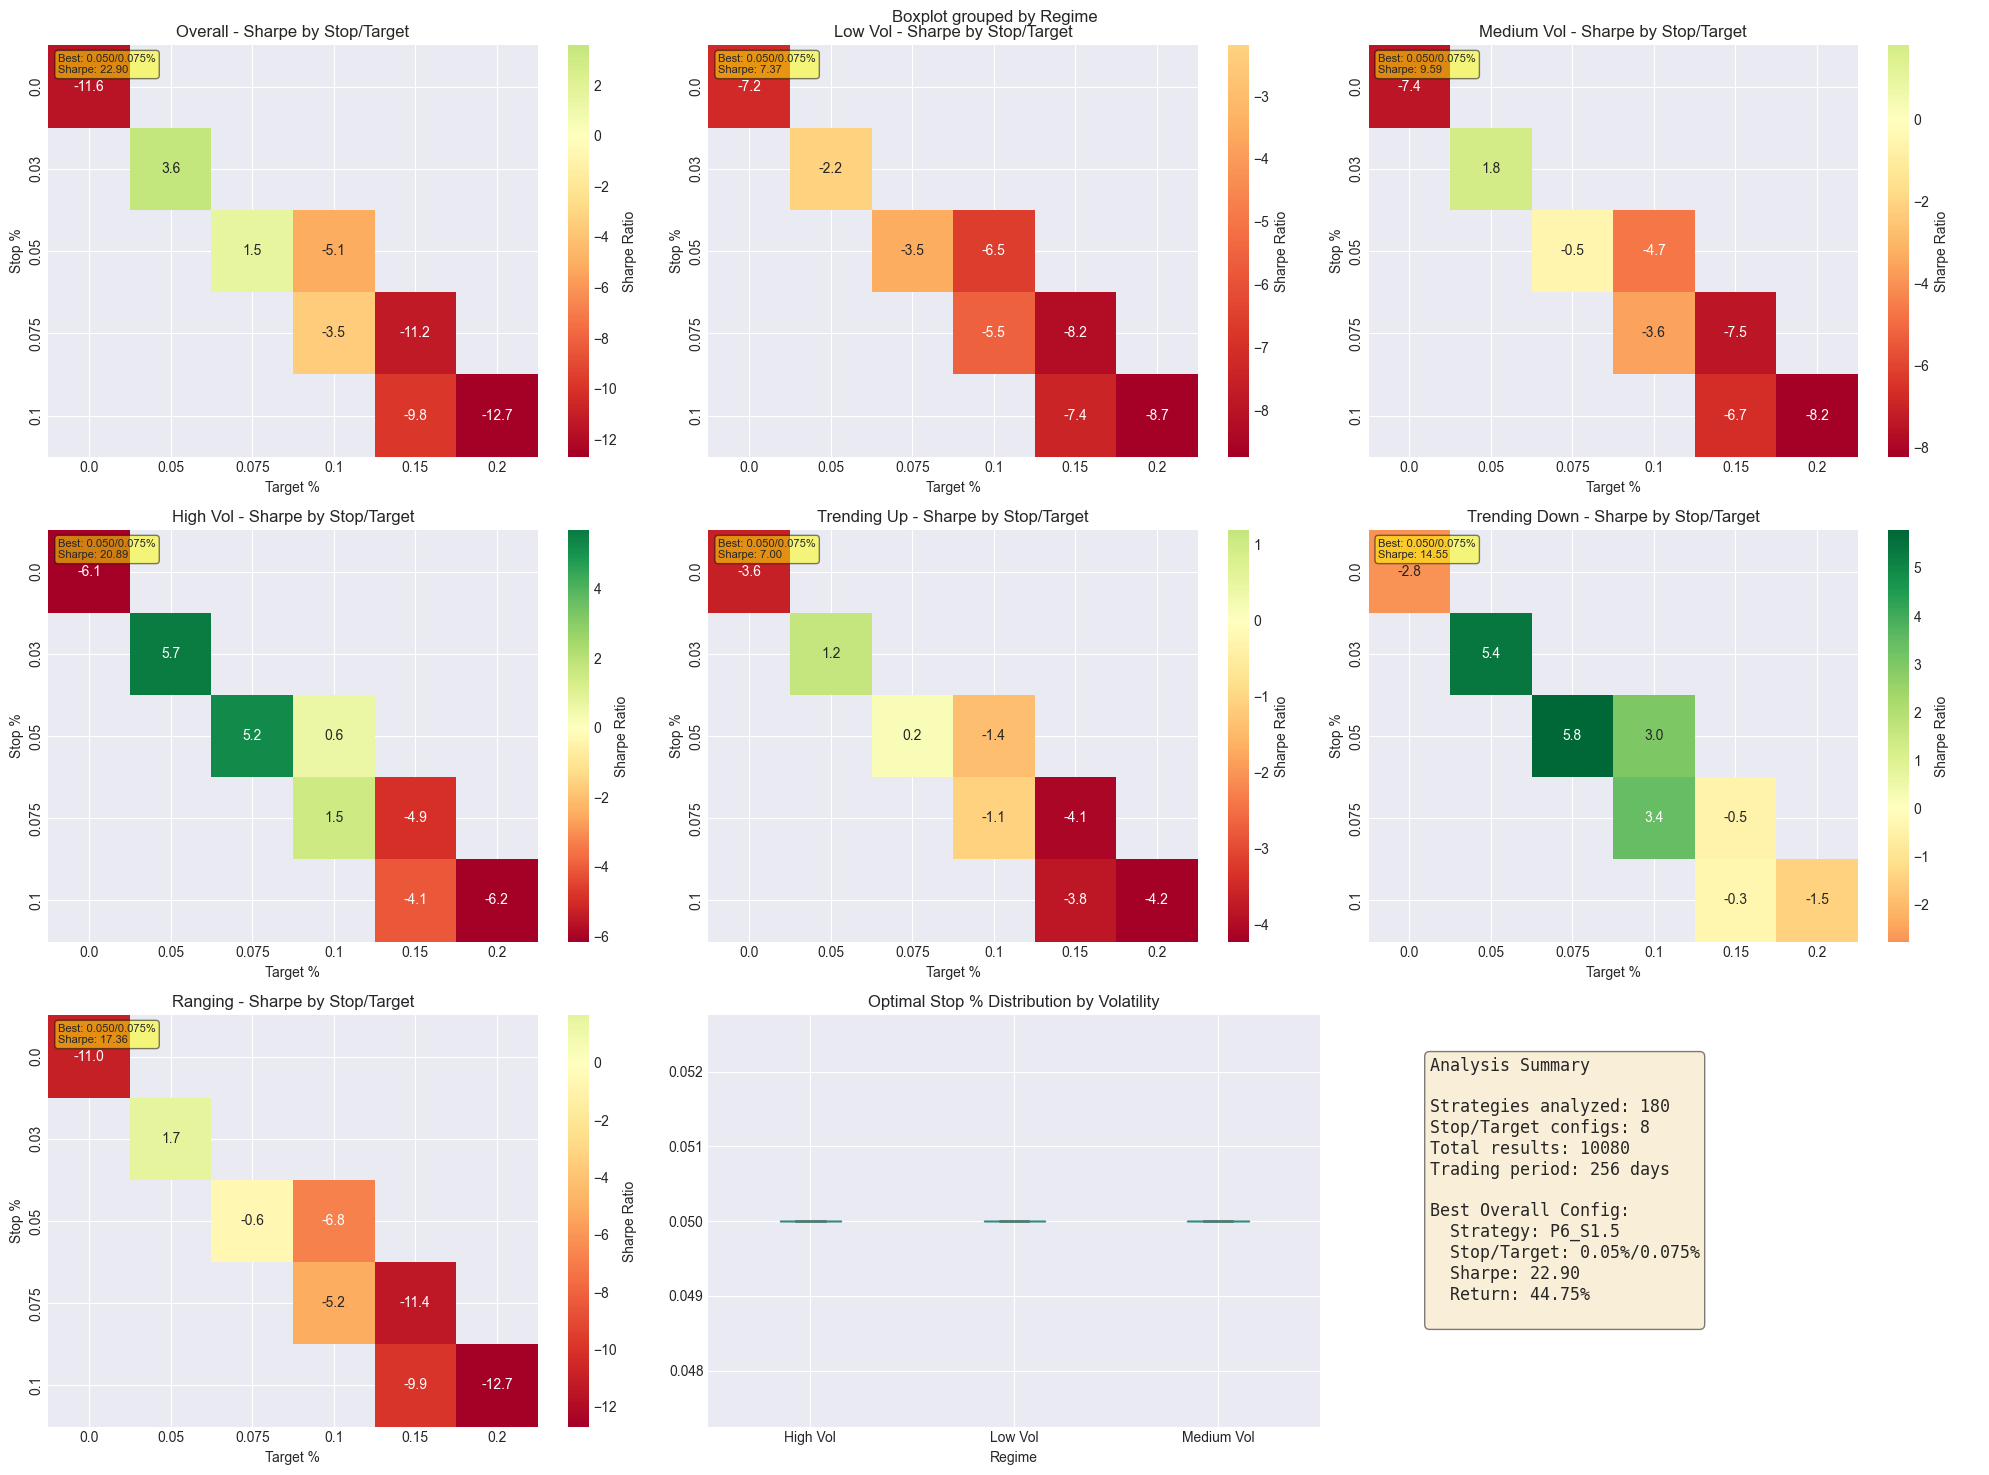


✅ Results saved to: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742/comprehensive_bollinger_analysis.csv

💡 Next Steps:
1. Review regime-specific configurations
2. Implement adaptive stop/target based on current regime
3. Consider tighter stops for 1-minute vs 5-minute data
4. Test on out-of-sample data with regime adaptation


In [97]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/comprehensive_bollinger_full_featured.py


📊 Trailing Stop/Target Analysis for Bollinger Strategies
Loading market data...
Loaded SPY_1m.csv
Market data: 102236 rows from 2024-03-26 13:30:00 to 2025-04-02 19:23:00

Finding strategies with sufficient signals...
Testing 5 strategies with >1000 signals

Testing strategy 1/5: P48_S1.0 (3398 signals)
  Config 11/11...
Testing strategy 2/5: P43_S1.0 (3398 signals)
  Config 11/11...
Testing strategy 3/5: P42_S1.0 (3395 signals)
  Config 11/11...
Testing strategy 4/5: P47_S1.0 (3388 signals)
  Config 11/11...
Testing strategy 5/5: P45_S1.0 (3387 signals)
  Config 11/11...

Analysis complete!

🎯 TOP TRAILING CONFIGURATIONS BY SHARPE RATIO

P45_S1.0 - Stop: 0%, Target: 0%
  Sharpe: -10.22, Return: -49.02%, Win Rate: 44.8%
  Exits: Stop=0, Trail Stop=0, Target=0, Trail Target=0, Signal=3387

P48_S1.0 - Stop: 0%, Target: 0%
  Sharpe: -10.24, Return: -49.47%, Win Rate: 44.8%
  Exits: Stop=0, Trail Stop=0, Target=0, Trail Target=0, Signal=3398

P43_S1.0 - Stop: 0%, Target: 0%
  Sharpe: -10.3

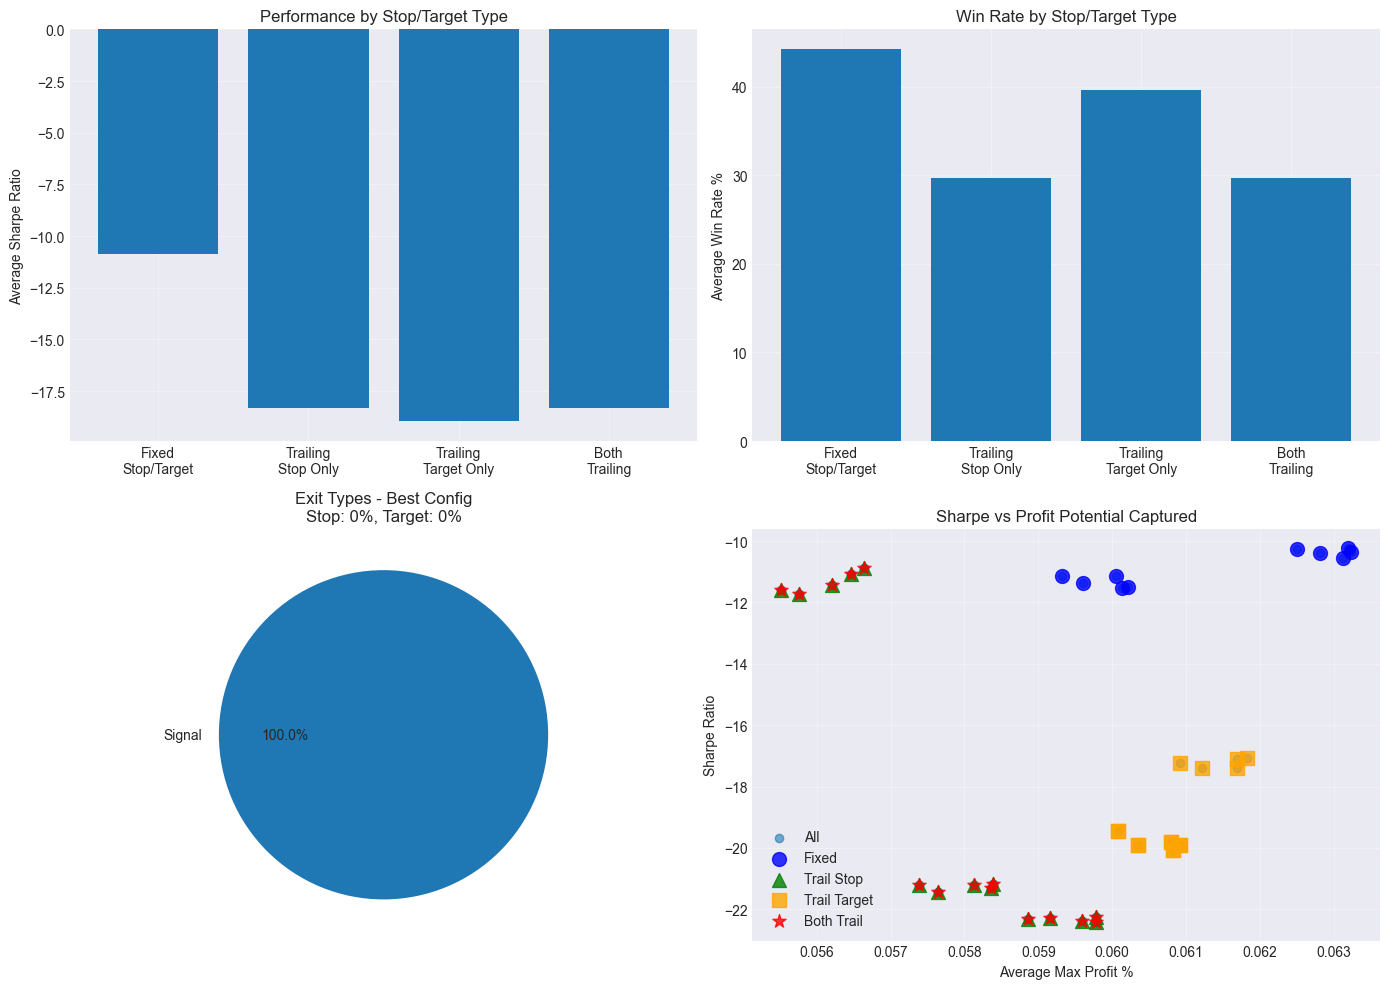


✅ Results saved to: /Users/daws/ADMF-PC/config/bollinger/results/20250625_185742/trailing_stop_target_analysis.csv

💡 KEY FINDINGS & RECOMMENDATIONS

1. TRAILING STOPS:
   - Average Sharpe with trailing stops: -18.31
   - Most effective trail distance: 0.050%

2. TRAILING TARGETS:
   - Average Sharpe with trailing targets: -18.64
   - Optimal activation level: Start trailing after 0.150% profit

3. OPTIMAL CONFIGURATION:
   - Stop: 0%, Target: 0%
   - Sharpe: -10.22, Return: -49.02%
   - This config captures 0.06% average max profit per trade



In [98]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/trailing_stop_target_analysis.py